In [4]:
from pathlib import Path
import json
from src.similarity import load_similarity_matrix
from omegaconf import OmegaConf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import matplotlib.colors as mcolors
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    auc
)
from functools import wraps
from typing import Iterable
from collections import defaultdict

seed = 1234
n_bs = 20
rng = np.random.default_rng(seed)

def bootstrap_metric(metric: callable, rng: np.random.Generator, n_bootstraps: int = 20) -> callable:
    """Bootstrap a metric calculation.

    Args:
        y_true (np.ndarray): True binary labels.
        y_pred_or_probas (np.ndarray): Predicted binary labels or probabilities.
        metric (callable): Metric function to be bootstrapped. Should take y_true and y_pred as arguments.
        threshold (float, optional): Threshold to convert probabilities to binary labels. If None, y_pred_or_probas is assumed to be binary labels. Defaults to None.
        n_bootstraps (int, optional): Number of bootstrap samples. Defaults to 20.

    Returns:
        callable: A function that computes the bootstrapped metric and its 95% confidence interval.
    """
    @wraps(metric)
    def wrapper(y_true: Iterable[int], y_pred_or_probas: Iterable[float | int], threshold: float | None = None, n_bootstraps: int = n_bootstraps, rng: np.random.Generator = rng, *args, **kwargs) -> tuple[float, tuple[float, float]]:
        boot_metrics = []
        n = len(y_true)
        for _ in range(n_bootstraps):
            indices = rng.integers(0, n, n)
            if threshold is not None:
                y_pred_sample = (y_pred_or_probas[indices] >= threshold).astype(int)
            else:
                y_pred_sample = y_pred_or_probas[indices]
            y_true_sample = y_true[indices]
            boot_metric = metric(y_true_sample, y_pred_sample, *args, **kwargs)
            boot_metrics.append(boot_metric)
        boot_metrics = np.array(boot_metrics)
        mean_metric = np.mean(boot_metrics)
        lower_ci = np.percentile(boot_metrics, 2.5)
        upper_ci = np.percentile(boot_metrics, 97.5)
        return mean_metric, (lower_ci, upper_ci)
    return wrapper


def get_shades(color, n_shades=6):
    base_color = mcolors.to_rgba(color)
    return [mcolors.to_hex((base_color[0], base_color[1], base_color[2], base_color[3] * (i / n_shades))) for i in range(1, n_shades + 1)]

filepaths = OmegaConf.load("../configs/filepaths/base.yaml")
mlflow.set_tracking_uri(filepaths.tracking_uri)

discrete_metrics = {
    'f1': bootstrap_metric(f1_score, rng, n_bootstraps=n_bs),
    'binary_precision': bootstrap_metric(precision_score, rng, n_bootstraps=n_bs),
    'binary_recall': bootstrap_metric(recall_score, rng, n_bootstraps=n_bs),
    'accuracy': bootstrap_metric(accuracy_score, rng, n_bootstraps=n_bs),
}

continuous_metrics = {
    'roc_auc': bootstrap_metric(roc_auc_score, rng, n_bootstraps=n_bs),
}

def get_nm_indices(df: pd.DataFrame, neg_multiple: int, seed: int = seed) -> np.ndarray:
    _rng = np.random.default_rng(seed)
    neg_idxs = df[df['y'] == 0].index
    n_to_rm = len(neg_idxs) - (len(df[df['y'] == 1]) * neg_multiple)
 
    if n_to_rm <= 0:
        return np.array(df.index)
    n_to_keep = len(neg_idxs) - n_to_rm
    keep_idxs = _rng.choice(neg_idxs, size=n_to_keep, replace=False)
    all_idxs = np.concatenate((df[df['y'] == 1].index.to_numpy(), keep_idxs))
    return all_idxs

Wrangle top model run ids

In [5]:
top_models = pd.read_csv(Path(filepaths.artifacts) / "250209_top_models.csv", sep=',')
top_cgr = pd.read_csv(Path(filepaths.artifacts) / "250223_top_cgr_models.csv", sep=',')
second_wave = pd.read_csv(Path(filepaths.artifacts) / "251015_non_clip_v2_split_models.csv", sep=',')
second_wave = second_wave.loc[second_wave['data/split_idx'] == -1]
non_clip = pd.concat((top_models, top_cgr, second_wave), axis=0, ignore_index=True)
non_clip.head()

Start Time Duration                            Run ID  \
0  2025-02-07 13:21:04     3.9h  ff90895a6070499b8fdcdc0982526885   
1  2025-02-07 13:20:39     3.1h  8a155bc5673b4c6aa8667dd55755fe0b   
2  2025-02-07 13:20:39     3.1h  5ca6ba7b8aec4b81a366e9138b9c09b0   
3  2025-02-07 13:20:35     3.4h  2241478505f9497885d25b9a0dee3ffd   
4  2025-02-07 13:20:33     3.4h  e638683b53f84d0ba1c8f32794413e0e   

                  Name Source Type  \
0     dazzling-rat-180       LOCAL   
1      zealous-eel-839       LOCAL   
2     smiling-colt-432       LOCAL   
3  fortunate-panda-724       LOCAL   
4       burly-goat-264       LOCAL   

                                         Source Name     User    Status  \
0  /home/spn1560/.conda/envs/hiec/lib/python3.11/...  spn1560  FINISHED   
1  /home/spn1560/.conda/envs/hiec/lib/python3.11/...  spn1560  FINISHED   
2  /home/spn1560/.conda/envs/hiec/lib/python3.11/...  spn1560  FINISHED   
3  /home/spn1560/.conda/envs/hiec/lib/python3.11/...  spn1560  FINISHED   
4  /home/spn1560/.conda/envs/hiec/lib/python3.11/...  spn1560  FINISHED   

   X_d_transform batch_norm  ... val/accuracy val/binary_precision  \
0            NaN       True  ...     0.809866             0.963687   
1            NaN       True  ...     0.809679             0.972779   
2            NaN       True  ...     0.797277             0.969662   
3            NaN       True  ...     0.950560             0.979499   
4            NaN       True  ...     0.949125             0.977389   

   val/binary_recall    val/f1   val/mcc   val/prc   val/roc  val_loss  \
0           0.631624  0.762649  0.653961  0.921851  0.912527  0.762649   
1           0.624411  0.760160  0.656536  0.959718  0.961152  0.760160   
2           0.600536  0.741214  0.635536  0.947565  0.949833  0.741214   
3           0.919235  0.948325  0.902712  0.986876  0.986808  0.948325   
4           0.918329  0.946844  0.899774  0.984206  0.986065  0.946844   

  data/negative_sampling  reduce_X_d  
0                    NaN         NaN  
1                    NaN         NaN  
2                    NaN         NaN  
3                    NaN         NaN  
4                    NaN         NaN  

[5 rows x 52 columns]

In [6]:
id2name = {
    row['Run ID']: {'data': row['data/split_strategy'], 'model': row['model/name']}
    for _, row in non_clip.iterrows()
}

id2name['clipzyme/sprhea_v3_folded_pt_ns_rcmcs_outer_fold'] = {'data': 'rcmcs', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_drfp_outer_fold'] = {'data': 'drfp', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_esm_outer_fold'] = {'data': 'esm', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_random_reaction_outer_fold'] = {'data': 'random_reaction', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_random_reaction_center_outer_fold'] = {'data': 'random_reaction_center', 'model': 'clipzyme'}

In [7]:
best_thresholds = {}
for id in id2name.keys():
    if not (Path(filepaths.results) / 'predictions' / id / 'best_thresholds.json').exists():
        print(f"No thresholds saved for {id2name[id]}, skipping...")
        continue
    
    with open(Path(filepaths.results) / 'predictions' / id / 'best_thresholds.json', 'r') as f:
        this = json.load(f)

    best_thresholds[id] = {int(k): v for k, v in this.items()}


No thresholds saved for {'data': 'blosum', 'model': 'rc_agg'}, skipping...
No thresholds saved for {'data': 'blosum', 'model': 'rc_cxn'}, skipping...
No thresholds saved for {'data': 'blosum', 'model': 'mfp'}, skipping...
No thresholds saved for {'data': 'blosum', 'model': 'drfp'}, skipping...
No thresholds saved for {'data': 'blosum', 'model': 'bom'}, skipping...
No thresholds saved for {'data': 'blosum', 'model': 'cgr'}, skipping...
No thresholds saved for {'data': 'gsi', 'model': 'rc_cxn'}, skipping...
No thresholds saved for {'data': 'gsi', 'model': 'bom'}, skipping...
No thresholds saved for {'data': 'gsi', 'model': 'rc_agg'}, skipping...
No thresholds saved for {'data': 'gsi', 'model': 'mfp'}, skipping...
No thresholds saved for {'data': 'gsi', 'model': 'drfp'}, skipping...
No thresholds saved for {'data': 'gsi', 'model': 'cgr'}, skipping...


In [8]:
preds = {} # Model outputs
nm_keep_indices = {} # Downsampled indices
chance = {}
cols = ['data', 'model', 'neg_multiple', 'metric', 'mean', 'ci_lower', 'ci_upper', 'id']
evals = []
for id in best_thresholds.keys():
    target_output_path = Path(filepaths.results) / 'predictions' / id / 'target_output.parquet'
    target_output = pd.read_parquet(target_output_path)
    preds[id] = target_output
    keep_indices = {
        nm : get_nm_indices(target_output, neg_multiple=nm, seed=seed)
        for nm in best_thresholds[id].keys()
    }

    nm_keep_indices[id] = keep_indices
    for nm in best_thresholds[id].keys():
        th = best_thresholds[id][nm]
        keep_idx = nm_keep_indices[id][nm]
        _target_output = target_output.loc[keep_idx]
        for metric_name, discrete_metric in discrete_metrics.items():
            mean, (ci_l, ci_u) = discrete_metric(_target_output['y'].to_numpy(), _target_output['logits'].to_numpy(), threshold=th)
            evals.append(
                [
                    id2name[id]['data'],
                    id2name[id]['model'],
                    nm,
                    metric_name,
                    mean,
                    ci_l,
                    ci_u,
                    id
                ]
            )

        for metric_name, continuous_metric in continuous_metrics.items():
            mean, (ci_l, ci_u) = continuous_metric(_target_output['y'].to_numpy(), _target_output['logits'].to_numpy())
            evals.append(
                [
                    id2name[id]['data'],
                    id2name[id]['model'],
                    nm,
                    metric_name,
                    mean,
                    ci_l,
                    ci_u,
                    id
                ]
            )

metrics_table = pd.DataFrame(
    evals, columns=cols
)

for _, row in metrics_table.drop_duplicates(['data', 'neg_multiple']).iterrows():
    _target_output = preds[row['id']].loc[nm_keep_indices[row['id']][row['neg_multiple']]]
    for metric in discrete_metrics.keys():
        mean, (ci_l, ci_u) = discrete_metrics[metric](_target_output['y'].to_numpy(), rng.integers(0, 2, size=len(_target_output)))
        chance[(row['data'], row['neg_multiple'], metric)] = mean

metrics_table.head()

data model  neg_multiple            metric      mean  ci_lower  ci_upper  \
0  rcmcs   bom             1                f1  0.826988  0.821753  0.833411   
1  rcmcs   bom             1  binary_precision  0.920678  0.913462  0.925909   
2  rcmcs   bom             1     binary_recall  0.749858  0.741530  0.764704   
3  rcmcs   bom             1          accuracy  0.841917  0.836631  0.847001   
4  rcmcs   bom             1           roc_auc  0.908744  0.904906  0.913436   

                                 id  
0  ff90895a6070499b8fdcdc0982526885  
1  ff90895a6070499b8fdcdc0982526885  
2  ff90895a6070499b8fdcdc0982526885  
3  ff90895a6070499b8fdcdc0982526885  
4  ff90895a6070499b8fdcdc0982526885

In [9]:
for gb in metrics_table.groupby(['data', 'neg_multiple', 'metric']):
    print(gb[0])
    print(gb[1][['model', 'mean', 'ci_lower', 'ci_upper']].to_markdown())
    print()

('drfp', np.int64(1), 'accuracy')
|     | model    |     mean |   ci_lower |   ci_upper |
|----:|:---------|---------:|-----------:|-----------:|
| 443 | rc_agg   | 0.932211 |   0.929143 |   0.935699 |
| 463 | rc_cxn   | 0.945391 |   0.941606 |   0.948233 |
| 483 | bom      | 0.92812  |   0.92571  |   0.930338 |
| 523 | drfp     | 0.896853 |   0.893198 |   0.90014  |
| 543 | mfp      | 0.906017 |   0.903053 |   0.909889 |
| 643 | cgr      | 0.938469 |   0.935657 |   0.940733 |
| 723 | clipzyme | 0.929198 |   0.925265 |   0.932574 |

('drfp', np.int64(1), 'binary_precision')
|     | model    |     mean |   ci_lower |   ci_upper |
|----:|:---------|---------:|-----------:|-----------:|
| 441 | rc_agg   | 0.93869  |   0.934559 |   0.941214 |
| 461 | rc_cxn   | 0.942198 |   0.938656 |   0.946117 |
| 481 | bom      | 0.925489 |   0.921493 |   0.929602 |
| 521 | drfp     | 0.956078 |   0.952652 |   0.961184 |
| 541 | mfp      | 0.950609 |   0.945969 |   0.953986 |
| 641 | cgr      | 0.939262

# Plotting

In [10]:
# Overall style

save_to = Path(filepaths.artifacts) / "figures" / "performance"

labels = {
    "rc_agg": "RC aggregated",
    "rc_cxn": "RC connected",
    "bom": "Bag of molecules",
    "cgr": "CGR",
    "clipzyme": "CLIPZyme",
    "drfp": "DRFP",
    "mfp": "Morgan fingerprint",
}

get_model_order = lambda x : [list(labels.keys()).index(elt) for elt in x]

colors = {
    "rc_agg": "purple",
    "rc_cxn": "forestgreen",
    "bom": "mediumblue",
    "cgr": "saddlebrown",
    "mfp": "black",
    "drfp": "dimgray",
    "clipzyme": "maroon",
}

metrics = {
    'f1': f1_score,
    'binary_precision': precision_score,
    'binary_recall': recall_score,
    'accuracy': accuracy_score
}

metric_names = {
    'f1': "F1",
    'binary_precision': "Precision",
    'binary_recall': "Recall",
    'accuracy': "Accuracy",
    'roc_auc': "ROC-AUC"
}

similarity_names = {
    'rcmcs': "RCMCS",
    'homology': "GSI",
    'drfp': "DRFP",
    'esm': "ESM",
    'random_reaction': "Random reaction",
    'random_reaction_center': "Random reaction center",
    'gsi': "GSI <25%"
}

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "axes.titlesize": 16,
})

ROC curves

In [11]:
figsize = (10, 5)
width = 0.75  # the width of the bars
xtick_rot = 45
xtick_ha = 'right'
ylim = (0.5, 1.0)

DRFP - Negative multiple 1


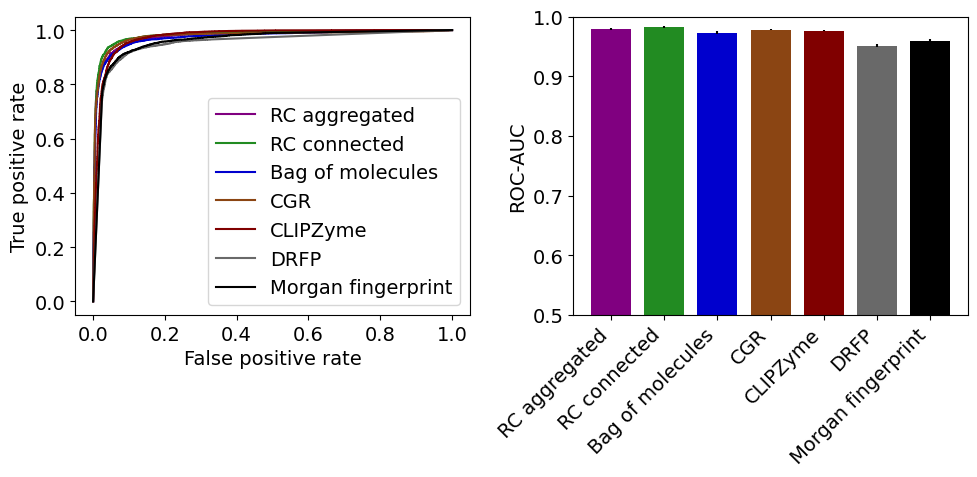

DRFP - Negative multiple 3


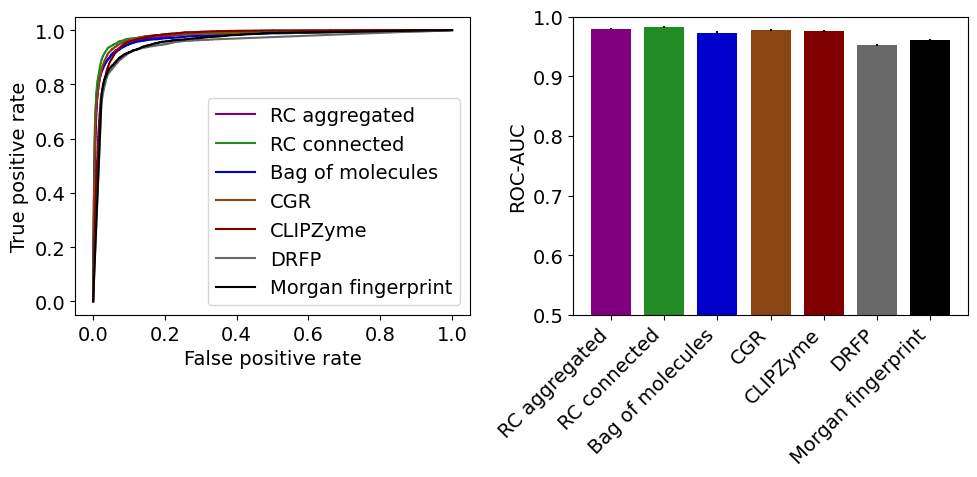

DRFP - Negative multiple 5


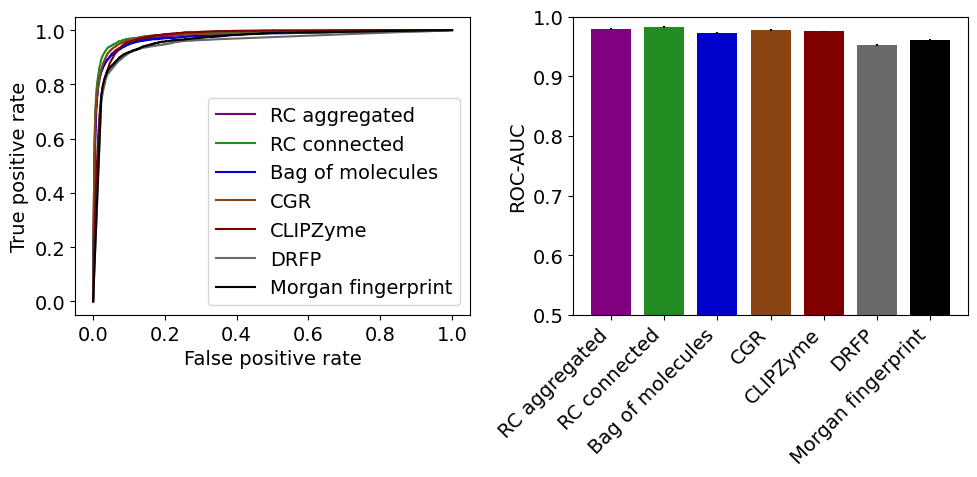

DRFP - Negative multiple 10


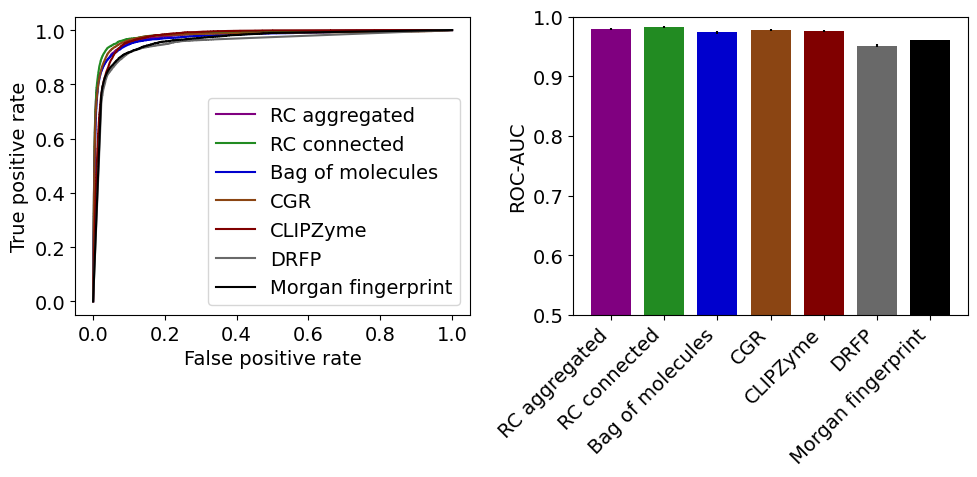

ESM - Negative multiple 1


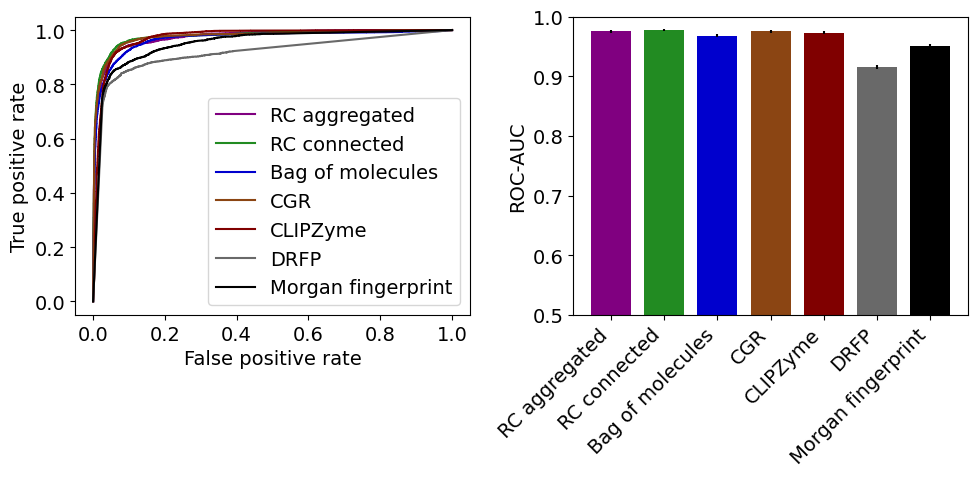

ESM - Negative multiple 3


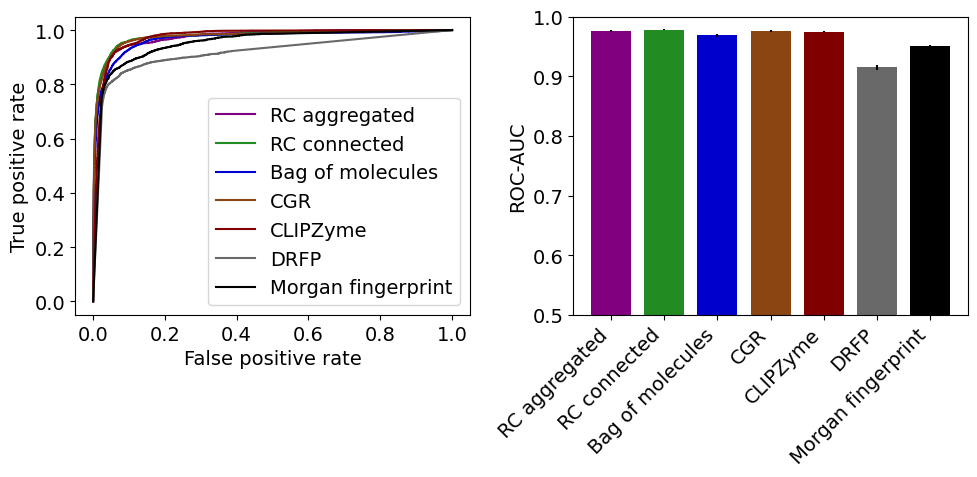

ESM - Negative multiple 5


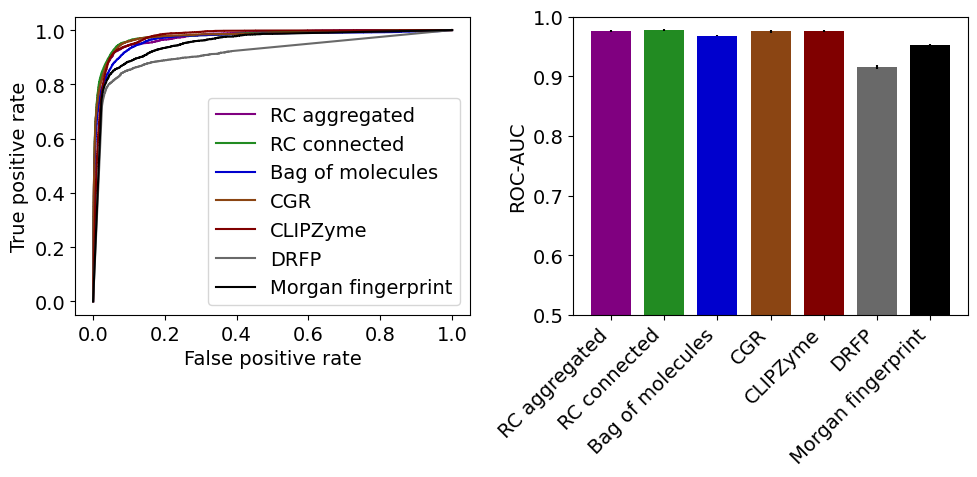

ESM - Negative multiple 10


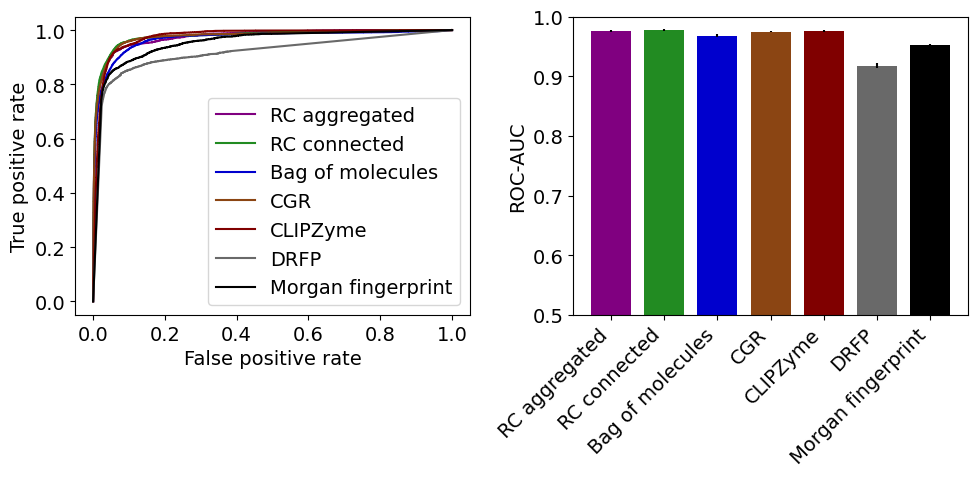

GSI - Negative multiple 1


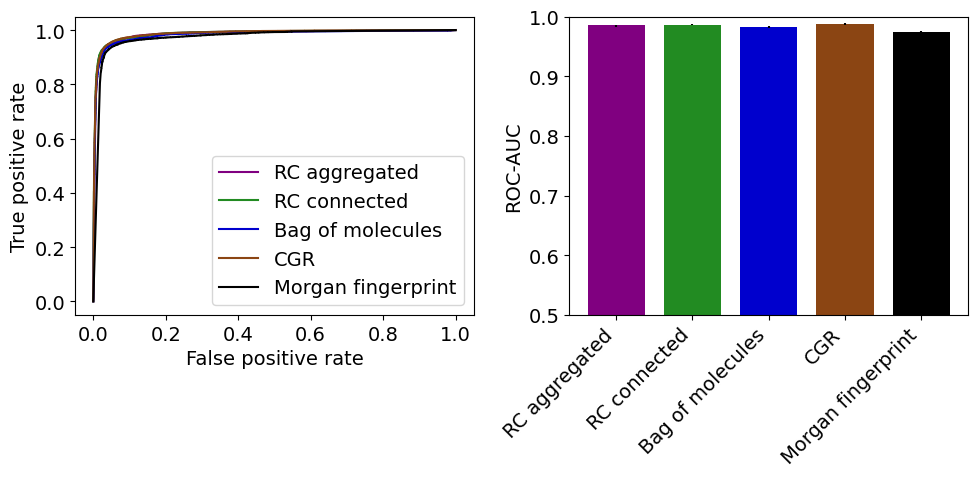

GSI - Negative multiple 3


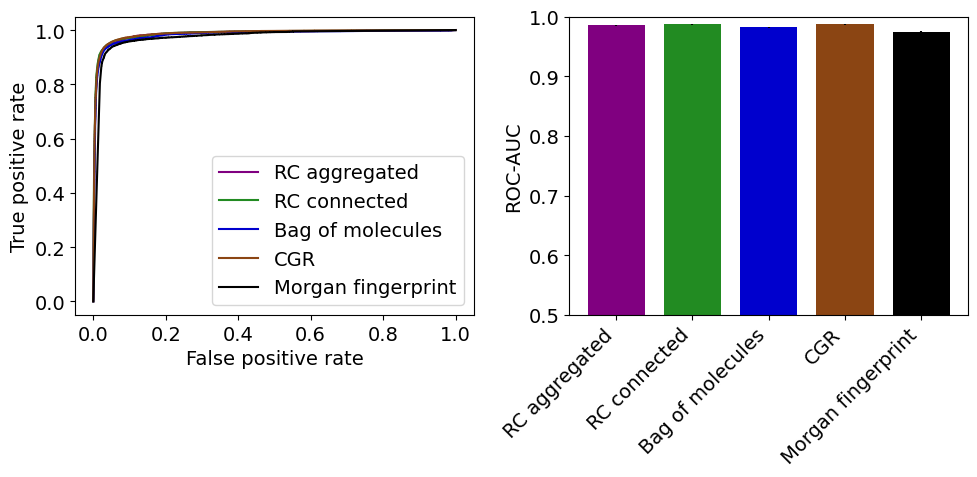

GSI - Negative multiple 5


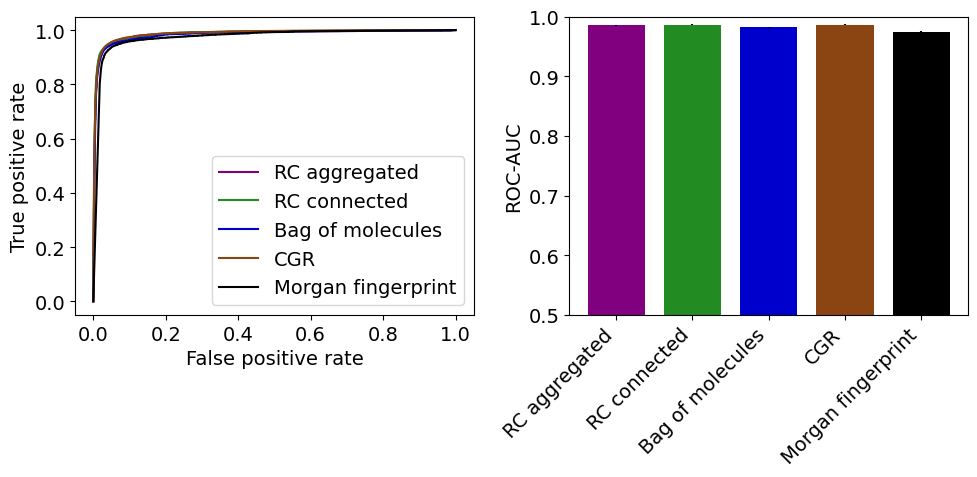

GSI - Negative multiple 10


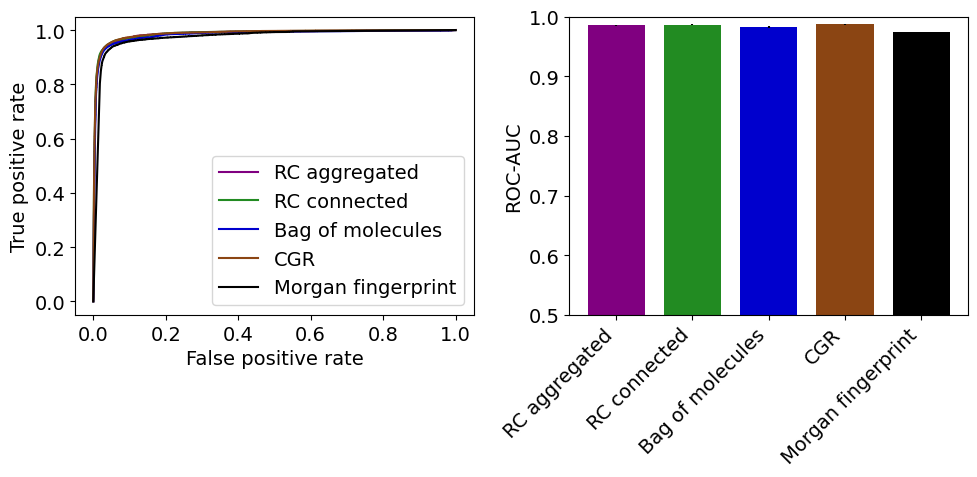

Random reaction - Negative multiple 1


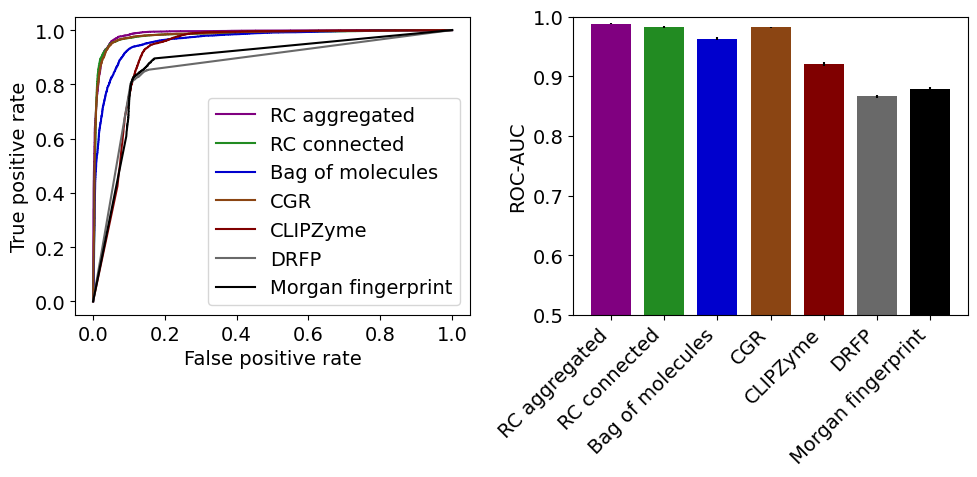

Random reaction - Negative multiple 3


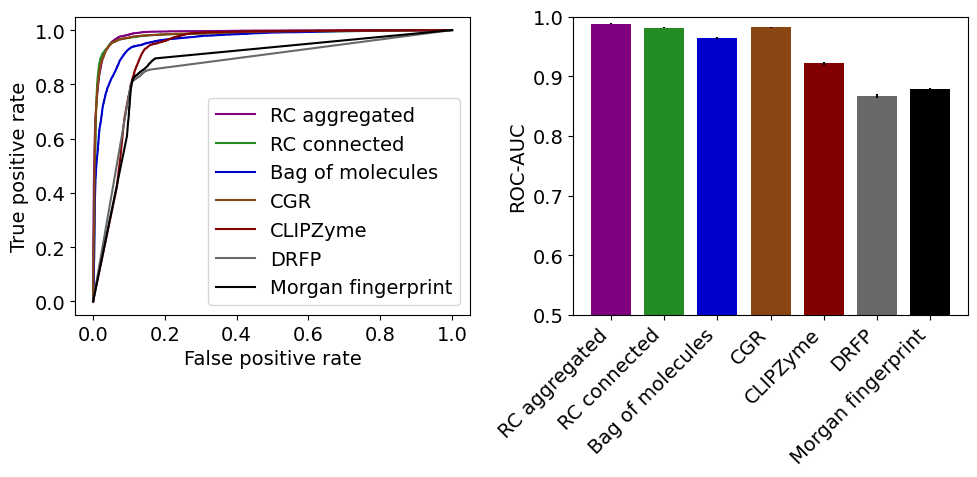

Random reaction - Negative multiple 5


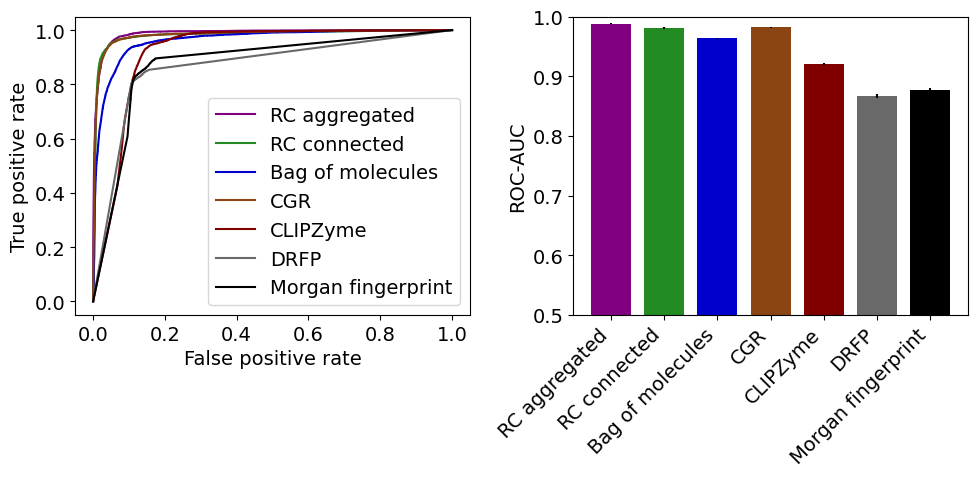

Random reaction - Negative multiple 10


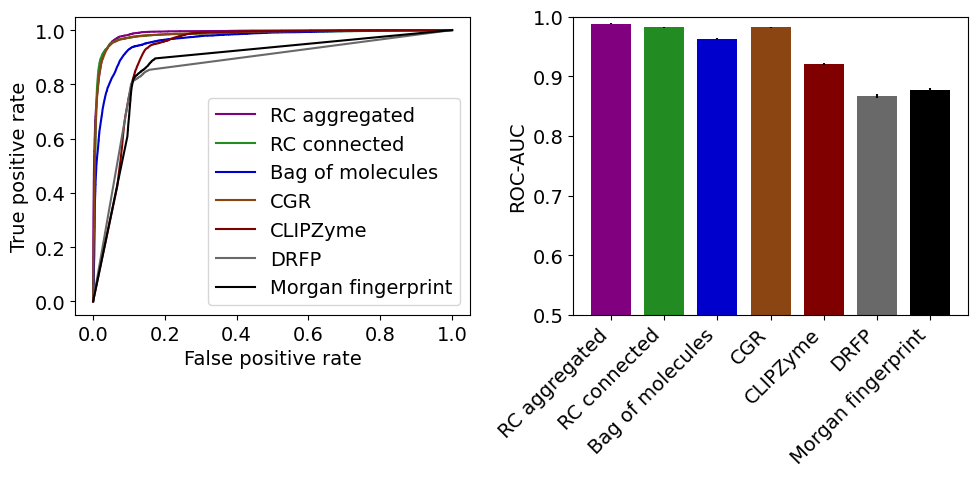

Random reaction center - Negative multiple 1


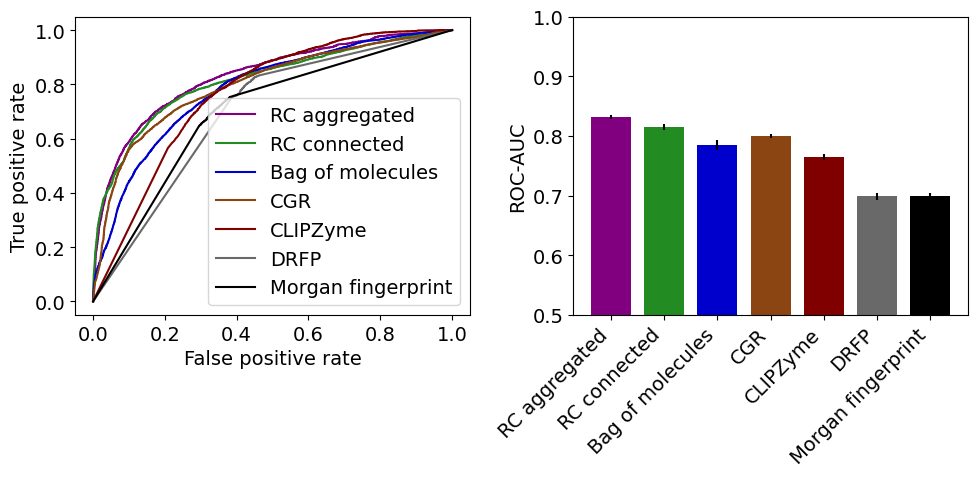

Random reaction center - Negative multiple 3


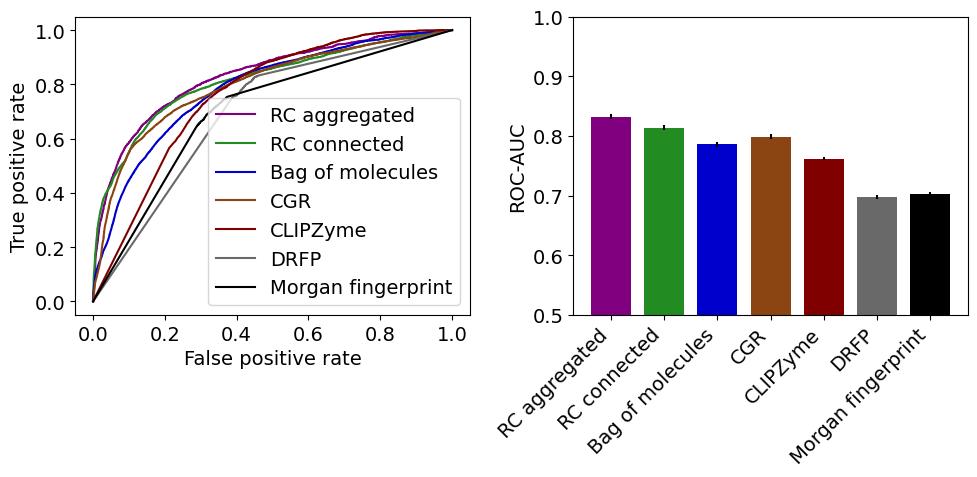

Random reaction center - Negative multiple 5


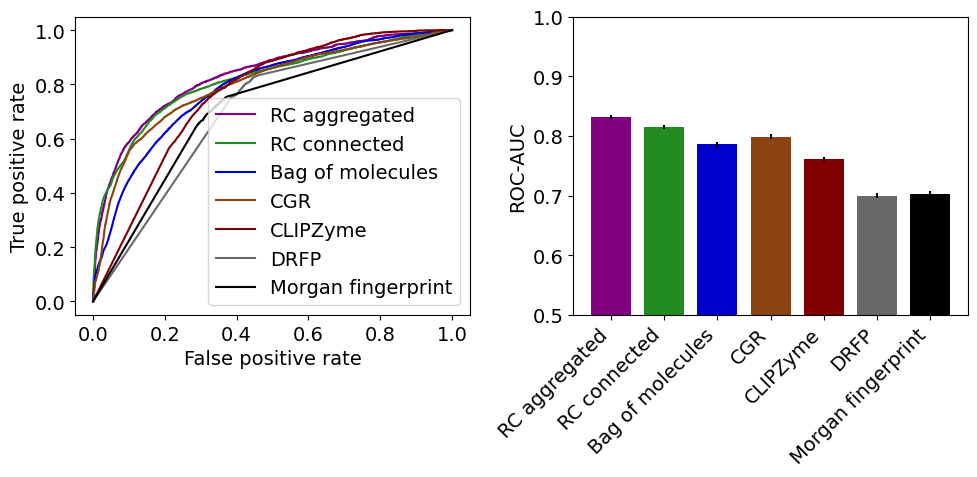

Random reaction center - Negative multiple 10


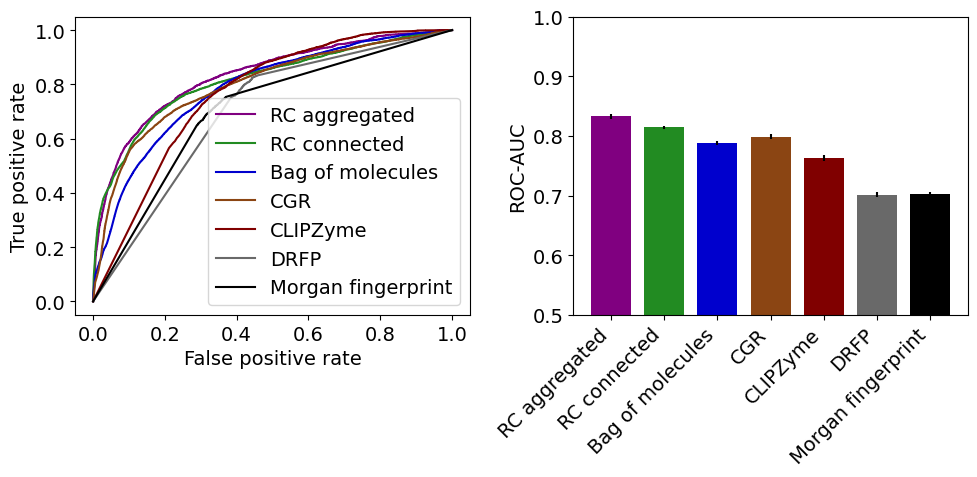

RCMCS - Negative multiple 1


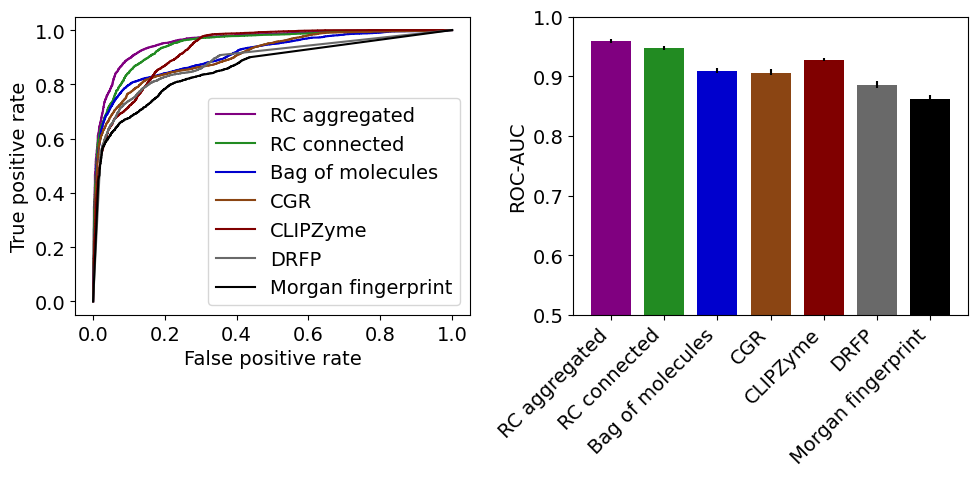

RCMCS - Negative multiple 3


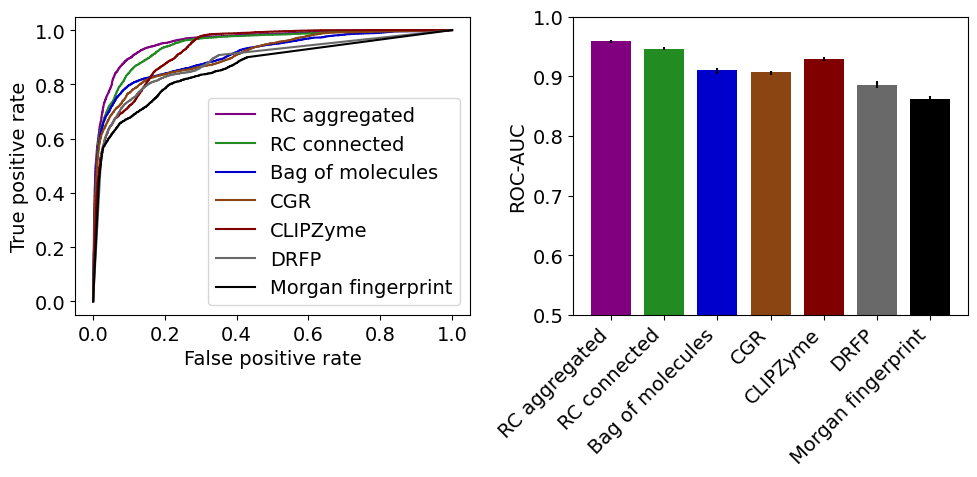

RCMCS - Negative multiple 5


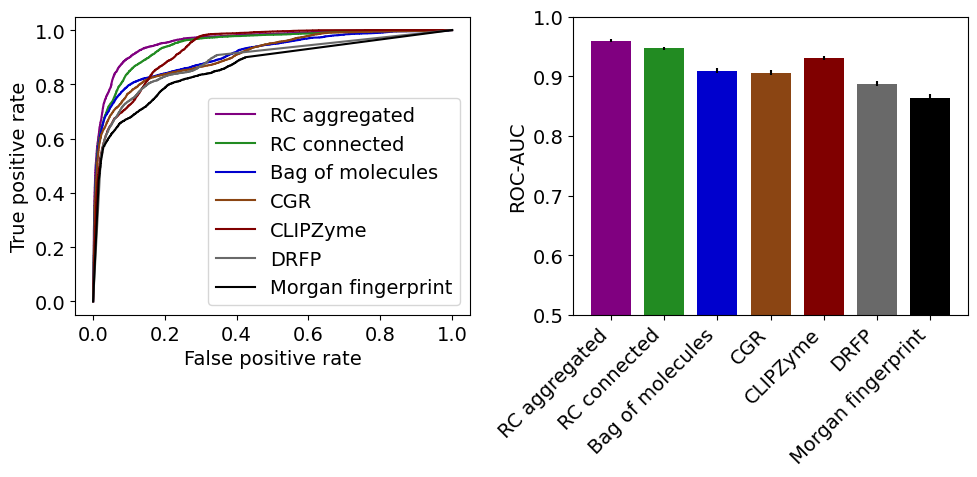

RCMCS - Negative multiple 10


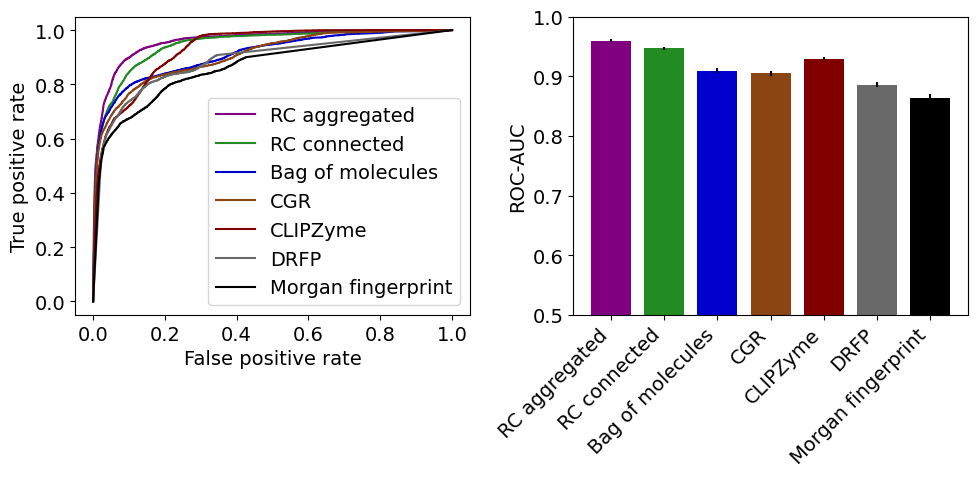

In [12]:
for (strat, nm), df in metrics_table.groupby(['data', 'neg_multiple']):
    roc_fig, roc_axs = plt.subplots(ncols=2, figsize=figsize)
    for _, row in df.drop_duplicates(['id', 'model']).sort_values(by='model', key=get_model_order).iterrows():
        id = row['id']
        model_name = row['model']
        pred = preds[id].loc[nm_keep_indices[id][nm]]
        prec, recall, _ = precision_recall_curve(pred['y'], pred['logits'])
        fpr, tpr, _ = roc_curve(pred['y'], pred['logits'])
        auroc_u, auroc_cil, auroc_ciu = df.loc[
            (df['id'] == id) & (df['model'] == model_name) & (df['metric'] == 'roc_auc'),
            ['mean', 'ci_lower', 'ci_upper']
        ].iloc[0].to_list()
        roc_axs[0].plot(fpr, tpr, color=colors[model_name], label=labels[model_name])

        ci = np.array([auroc_u - auroc_cil, auroc_ciu - auroc_u]).reshape(2, 1)
        roc_axs[1].bar(labels[model_name], height=auroc_u, width=width, yerr=ci, color=colors[model_name])
        
        roc_axs[1].set_ylabel("ROC-AUC")
        roc_axs[1].set_ylim(ylim)
        for label in roc_axs[1].get_xticklabels():
            label.set_rotation(xtick_rot)
            label.set_ha(xtick_ha)
    
    roc_axs[0].set_xlabel("False positive rate")
    roc_axs[0].set_ylabel("True positive rate")
    roc_axs[0].legend()
    print(f"{similarity_names[strat]} - Negative multiple {nm}")
    plt.tight_layout()
    plt.show()

Top models inner val metrics with test overlay

In [13]:
# Bar chart constants

figsize = (15, 5)
width = 0.75  # the width of the bars
xtick_rot = 60
xtick_ha = 'right'
scl_chance = 0.9
chance_color = 'orange'

DRFP - Negative multiple 1


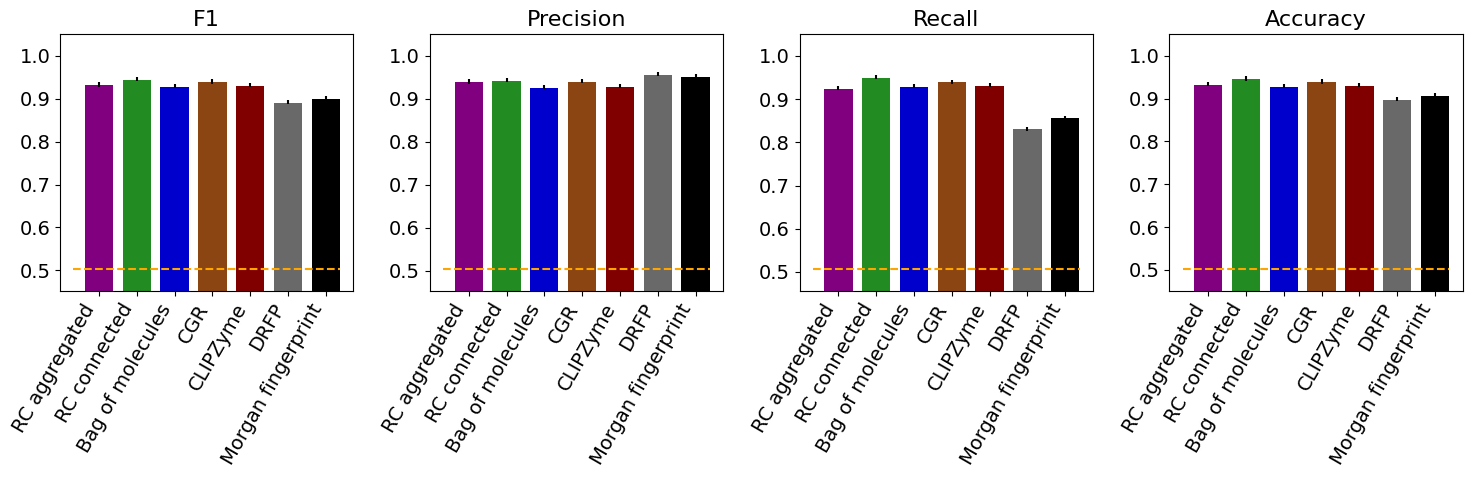

DRFP - Negative multiple 3


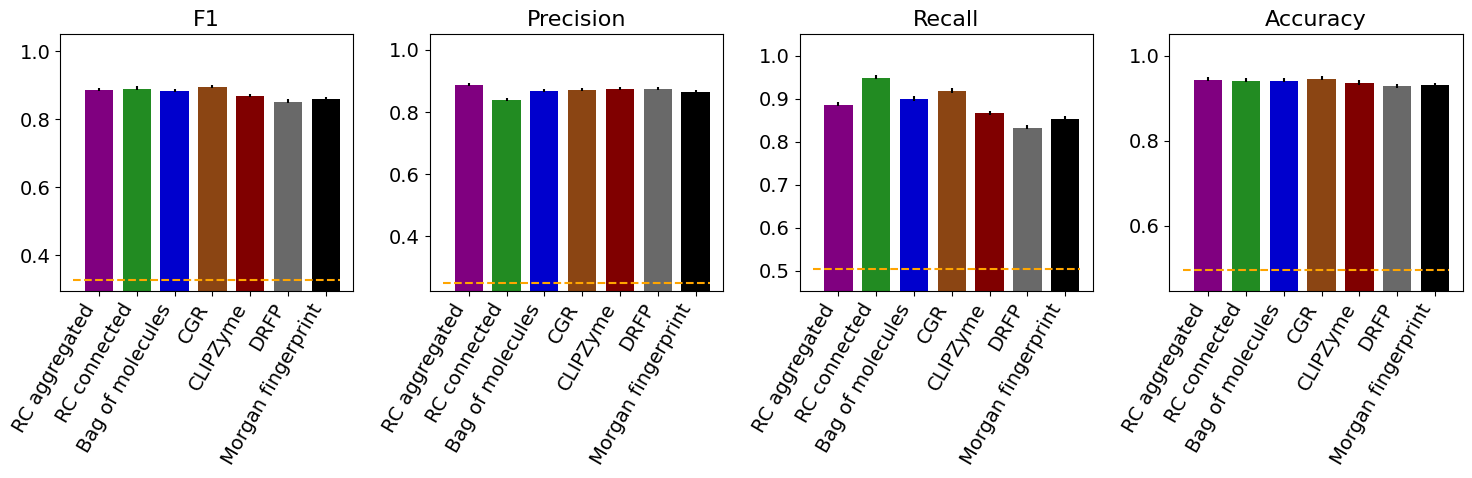

DRFP - Negative multiple 5


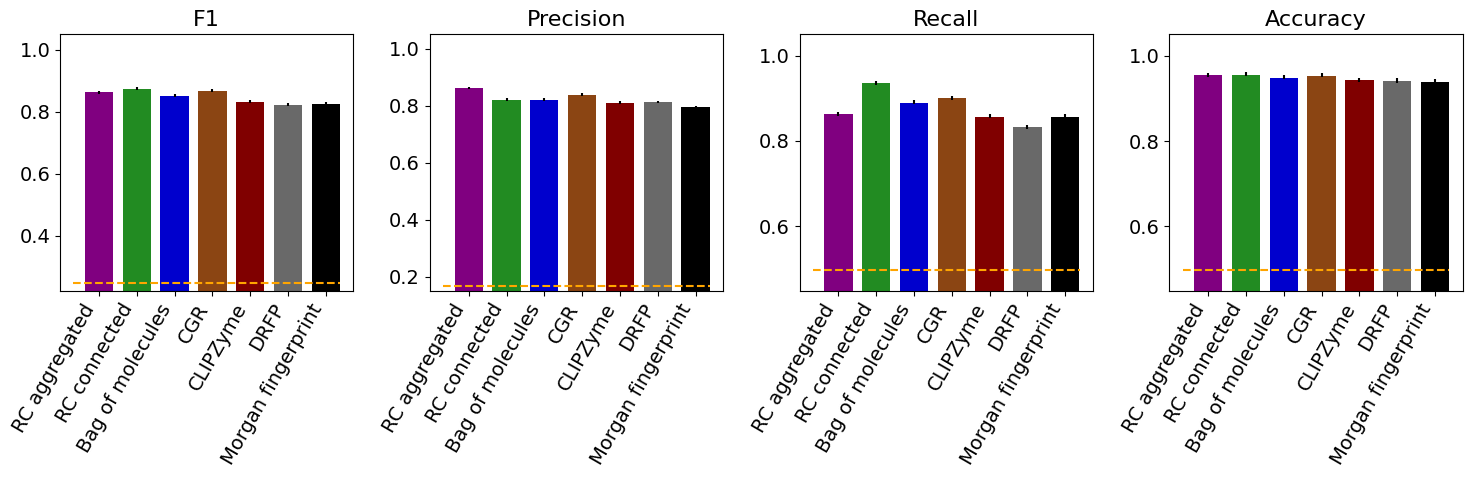

DRFP - Negative multiple 10


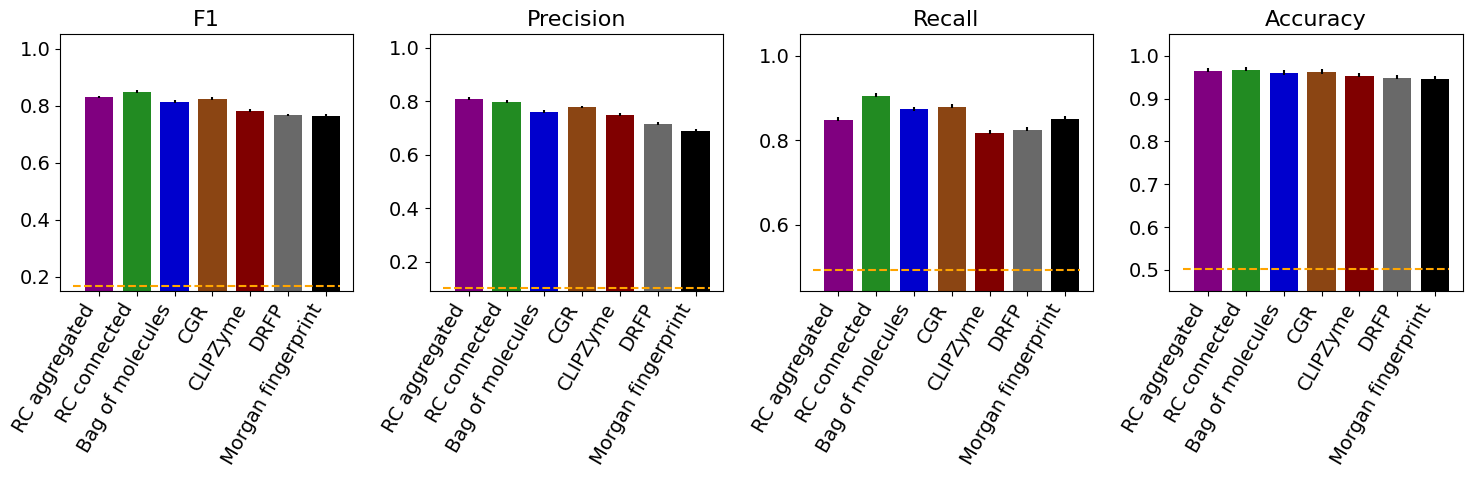

ESM - Negative multiple 1


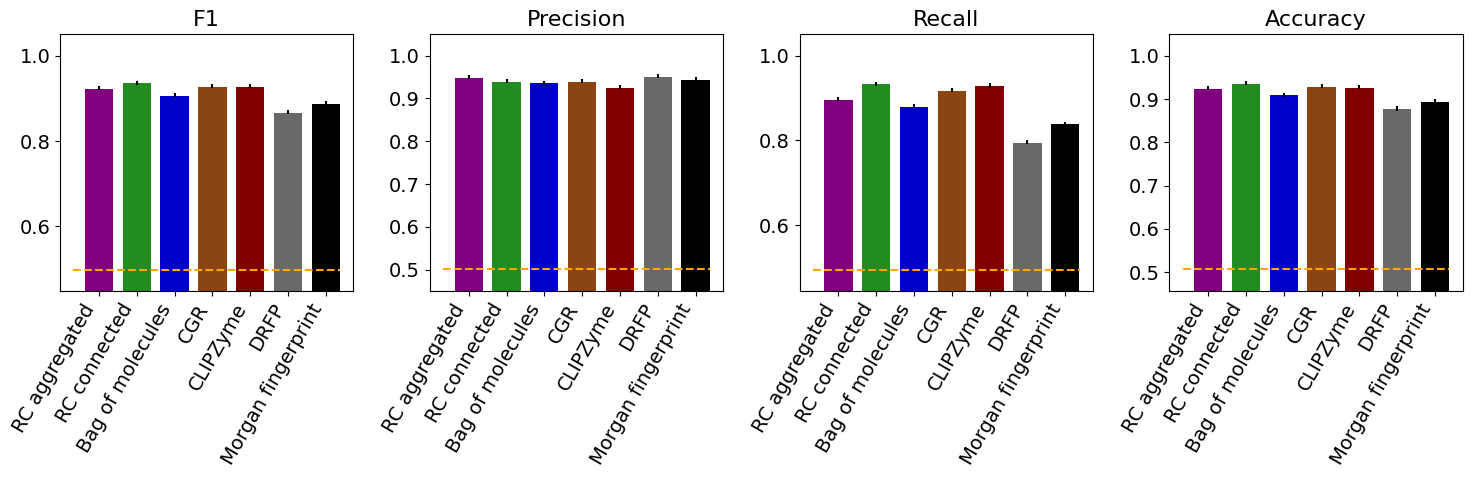

ESM - Negative multiple 3


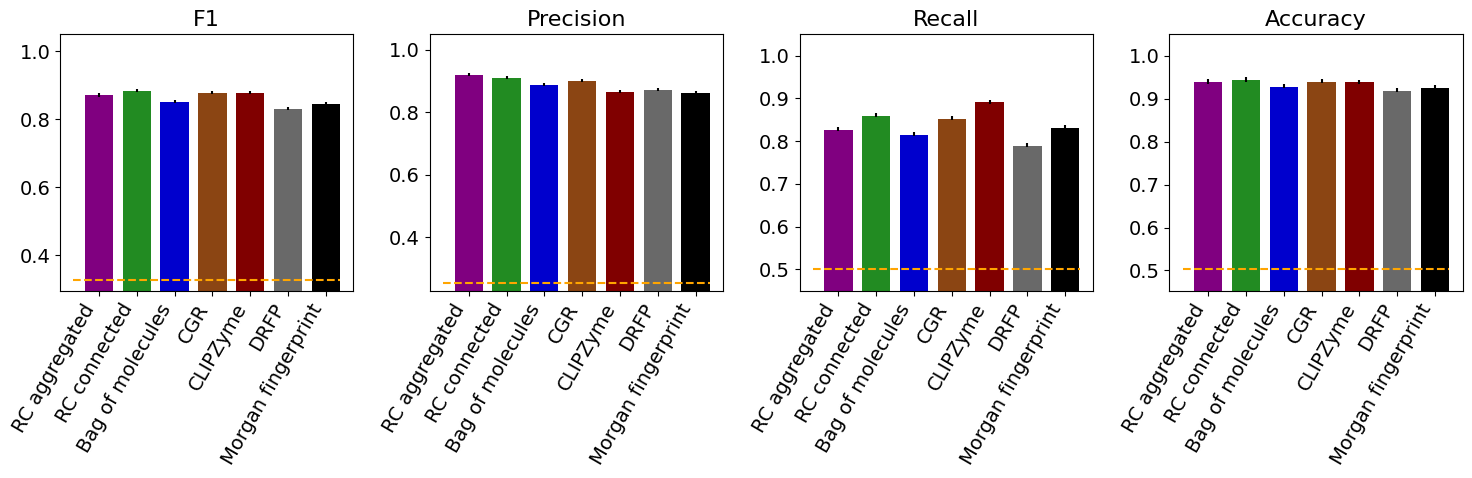

ESM - Negative multiple 5


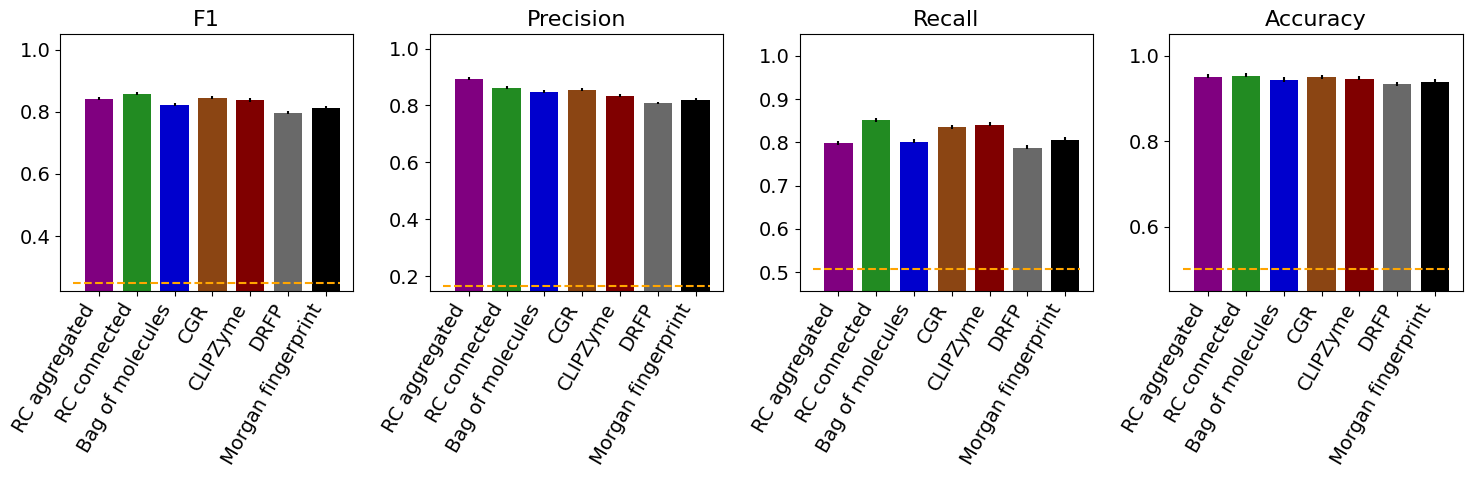

ESM - Negative multiple 10


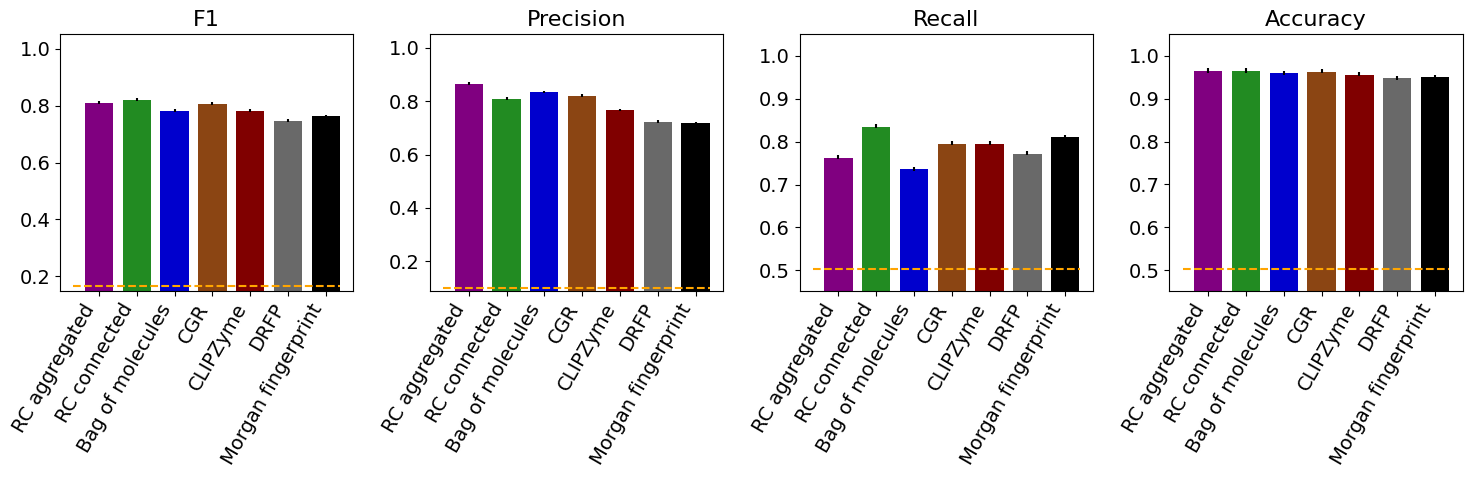

GSI - Negative multiple 1


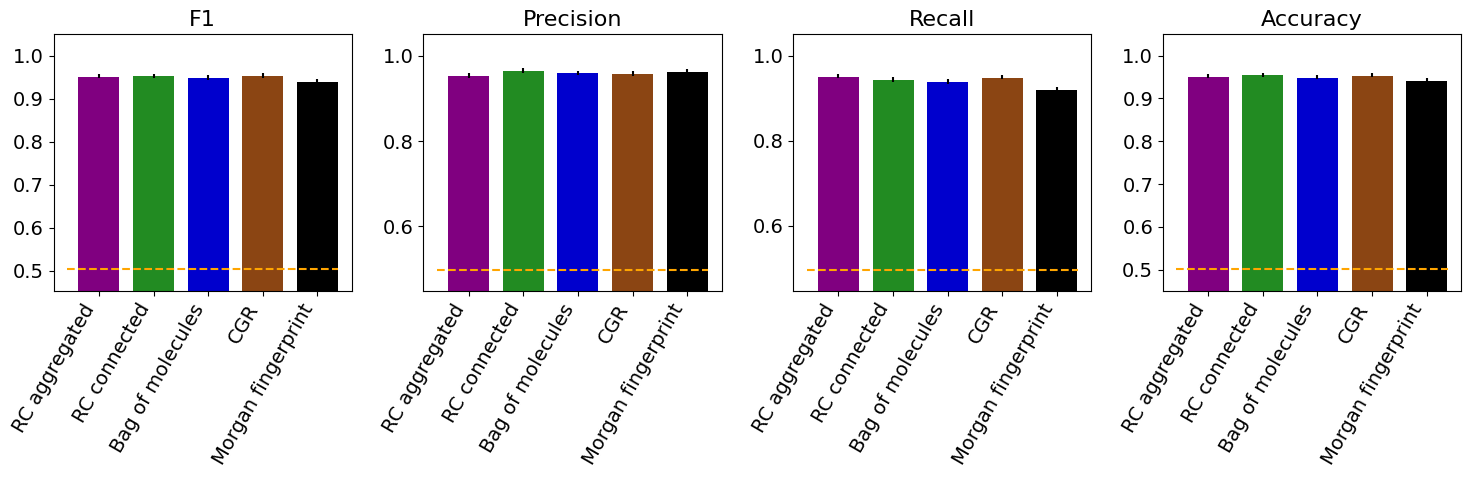

GSI - Negative multiple 3


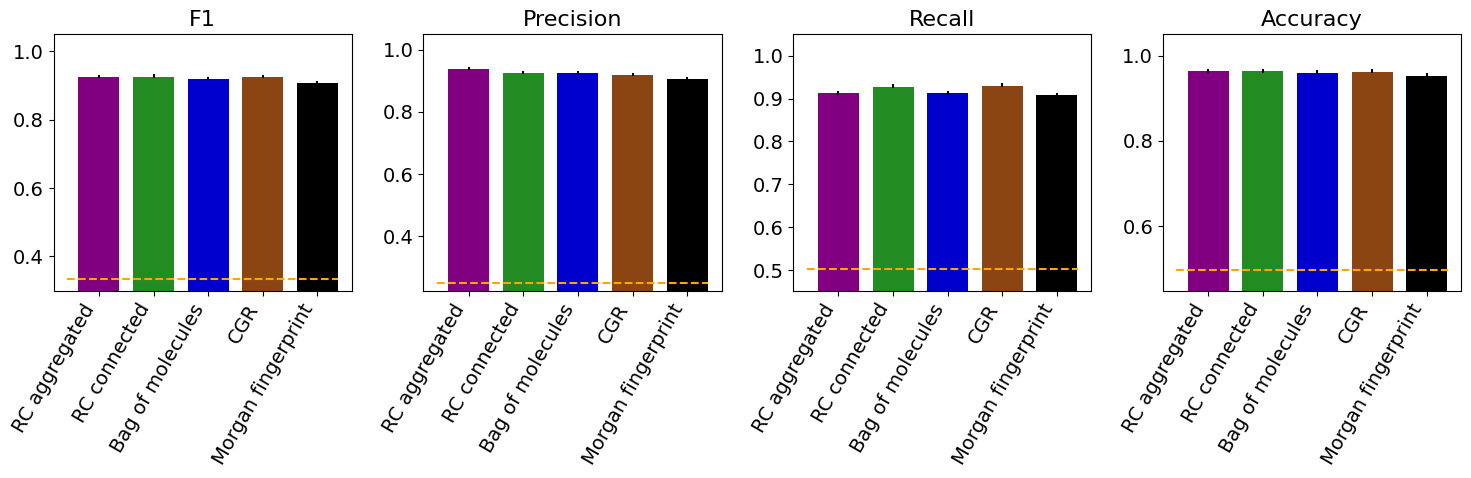

GSI - Negative multiple 5


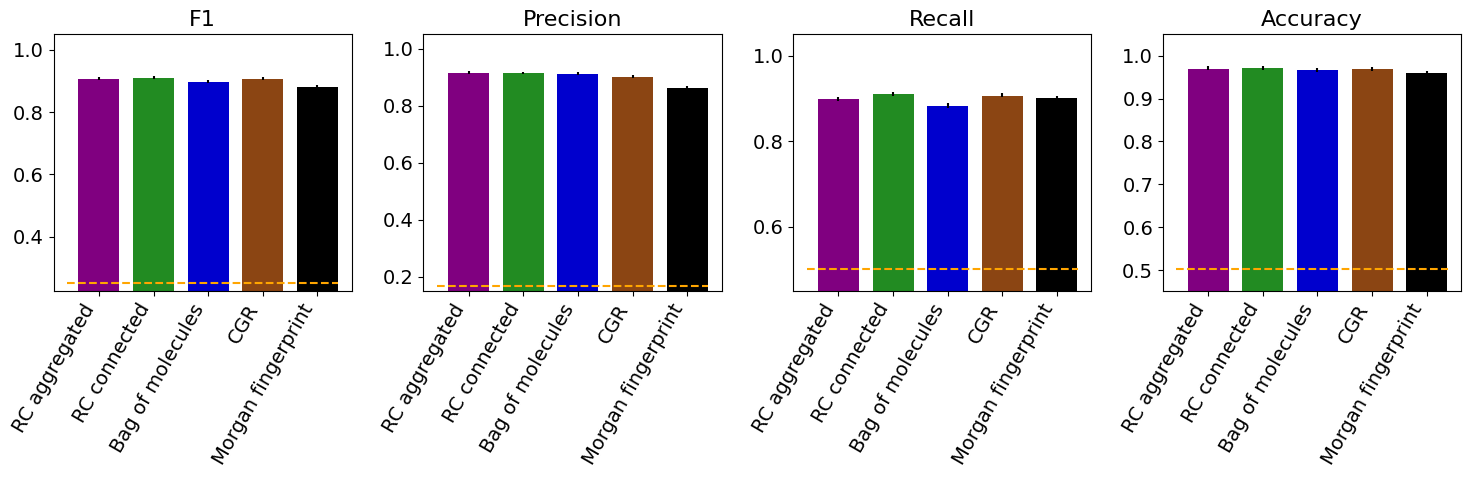

GSI - Negative multiple 10


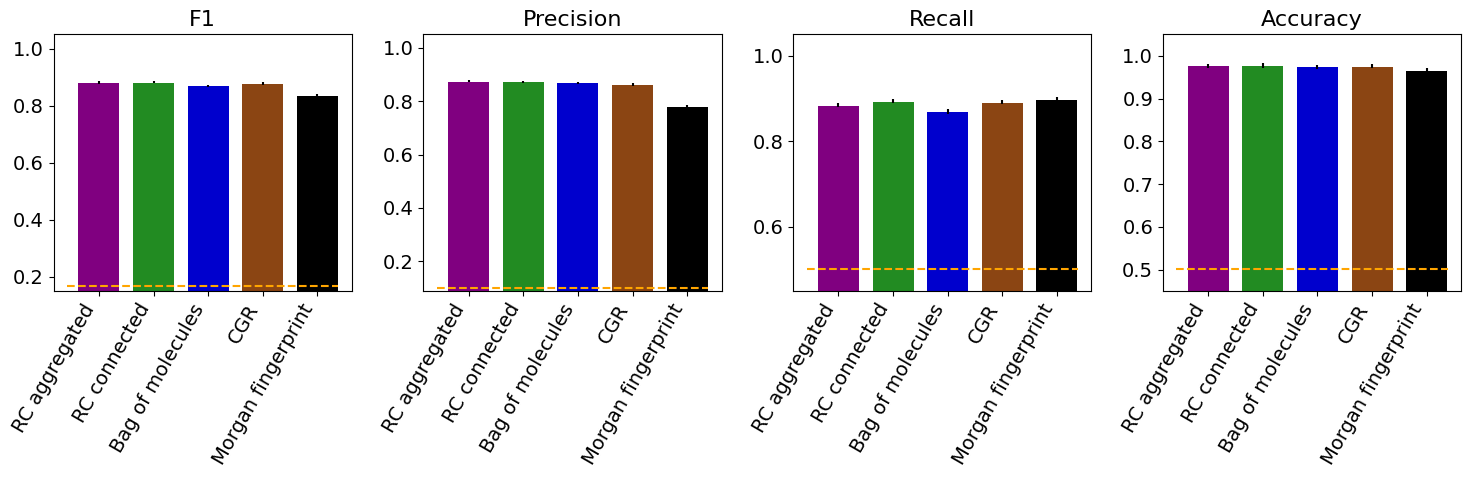

Random reaction - Negative multiple 1


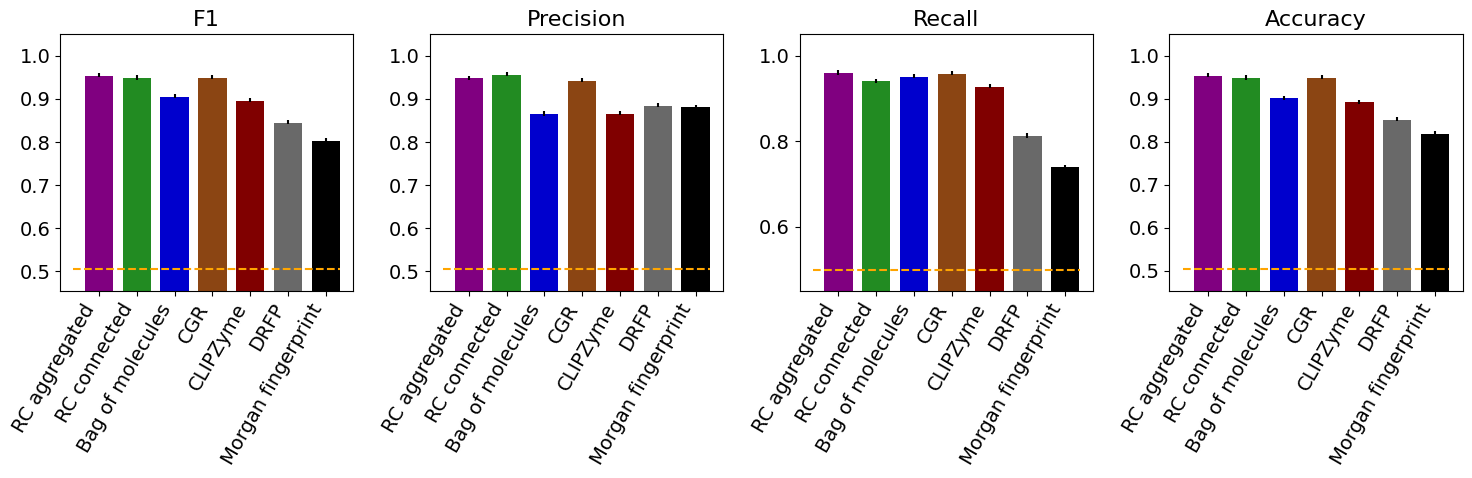

Random reaction - Negative multiple 3


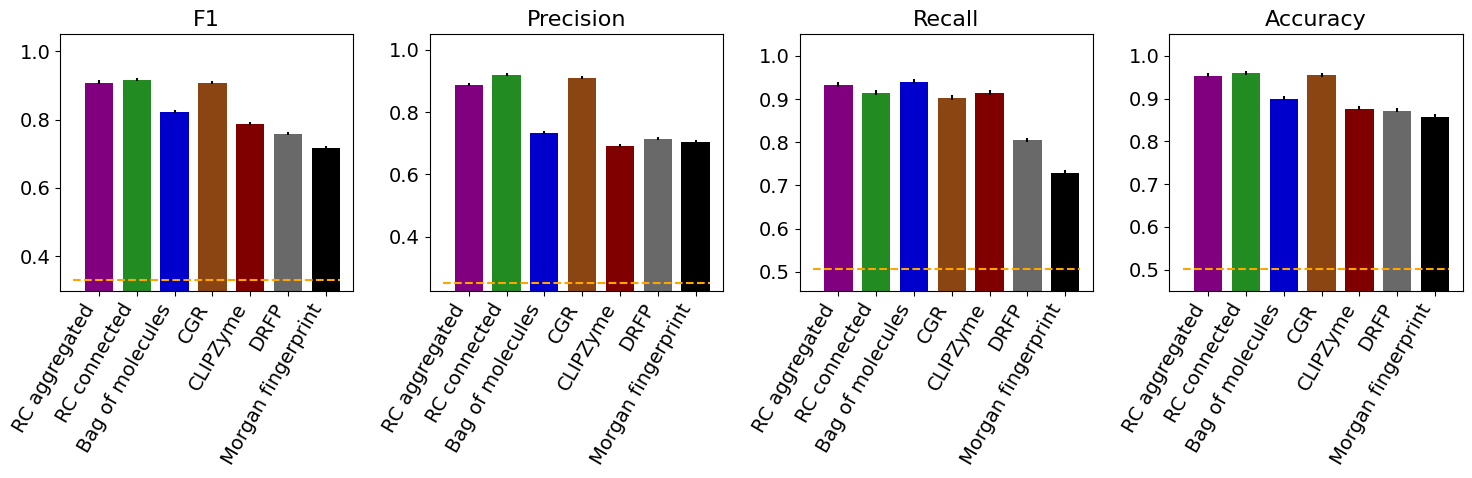

Random reaction - Negative multiple 5


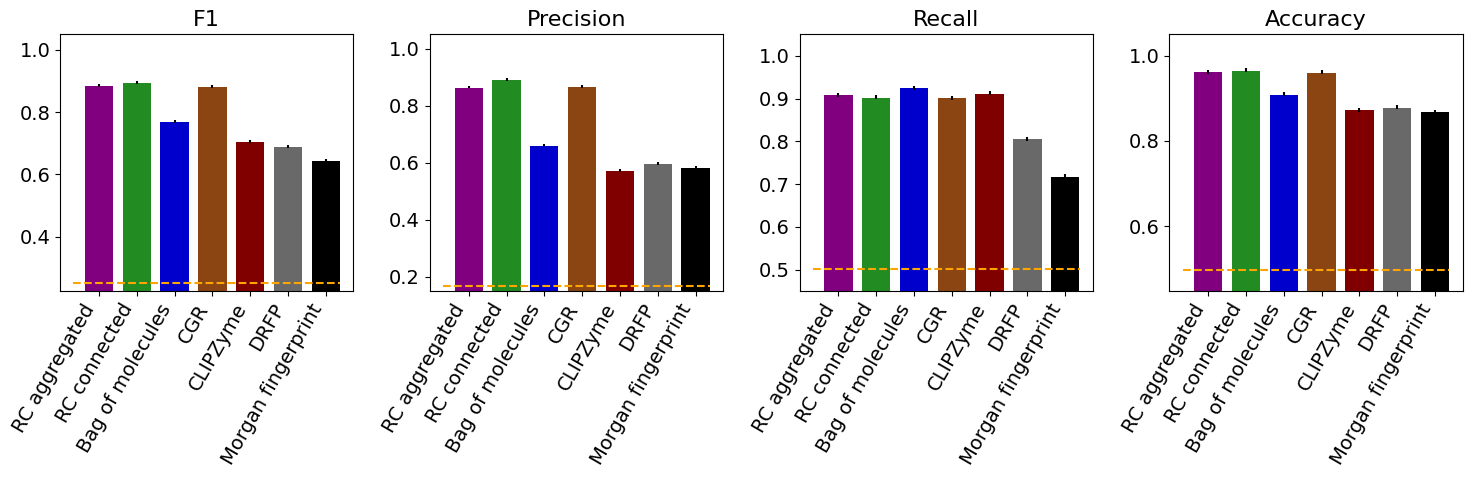

Random reaction - Negative multiple 10


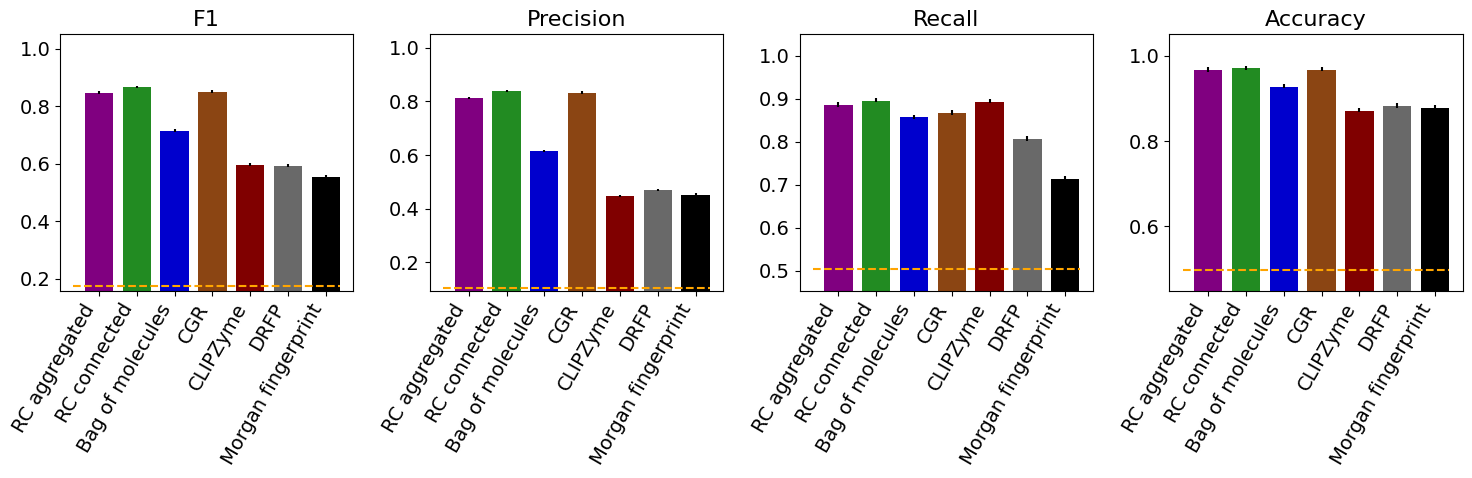

Random reaction center - Negative multiple 1


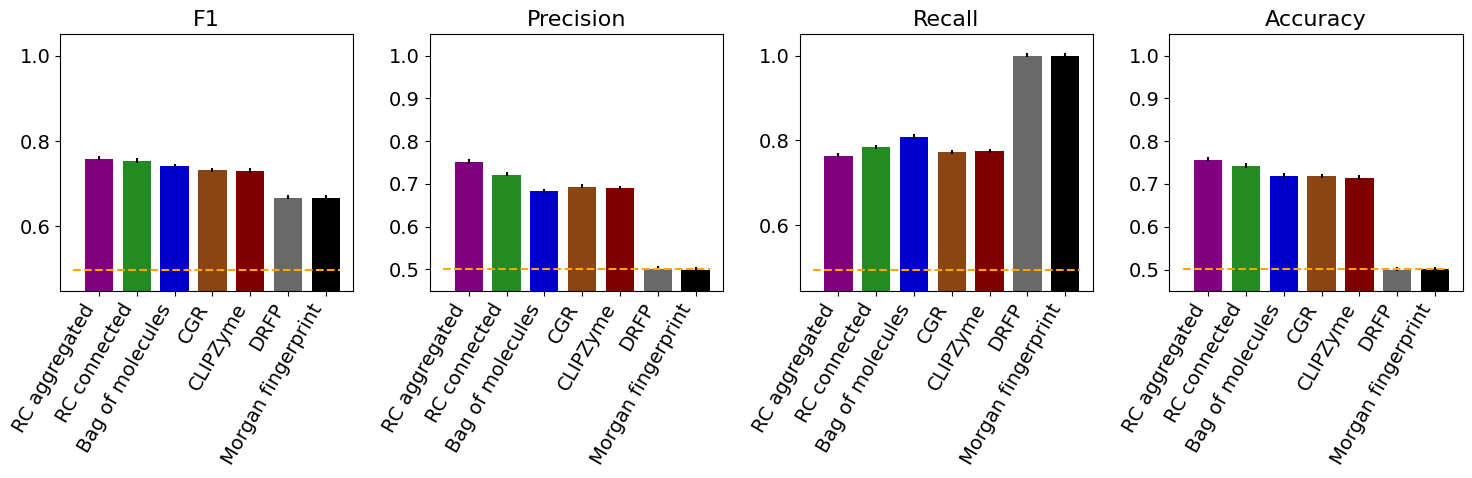

Random reaction center - Negative multiple 3


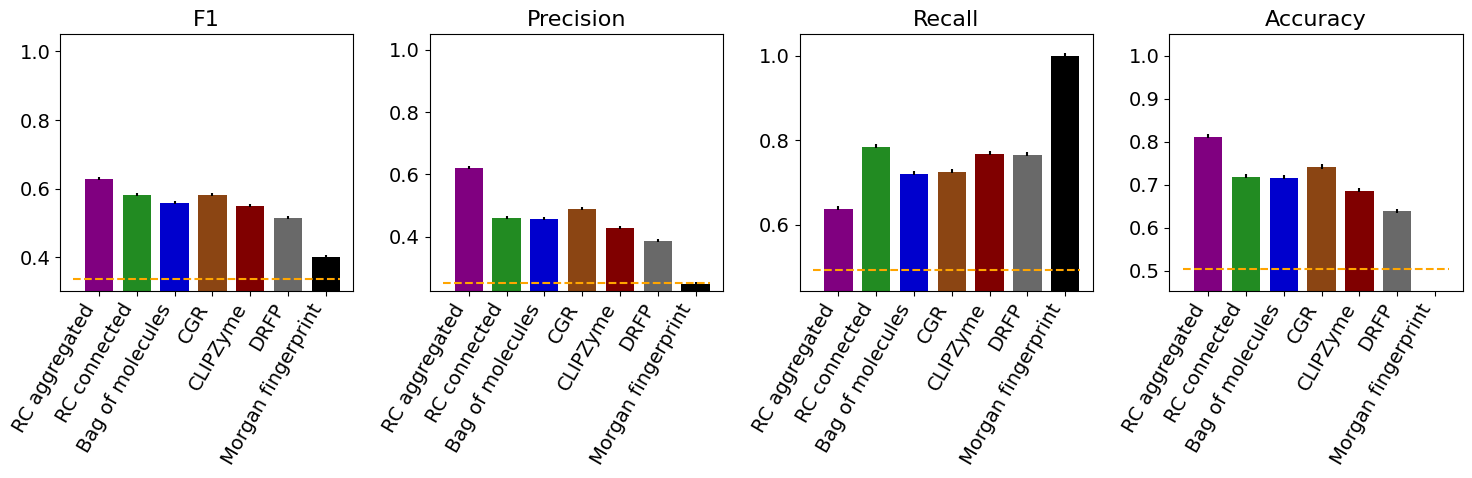

Random reaction center - Negative multiple 5


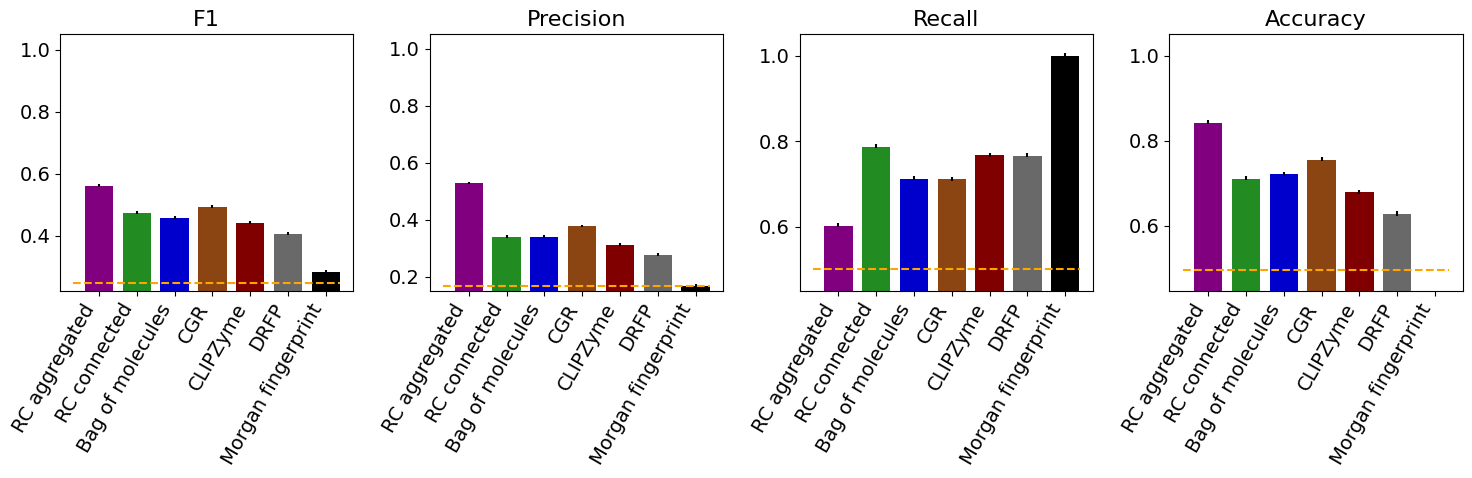

Random reaction center - Negative multiple 10


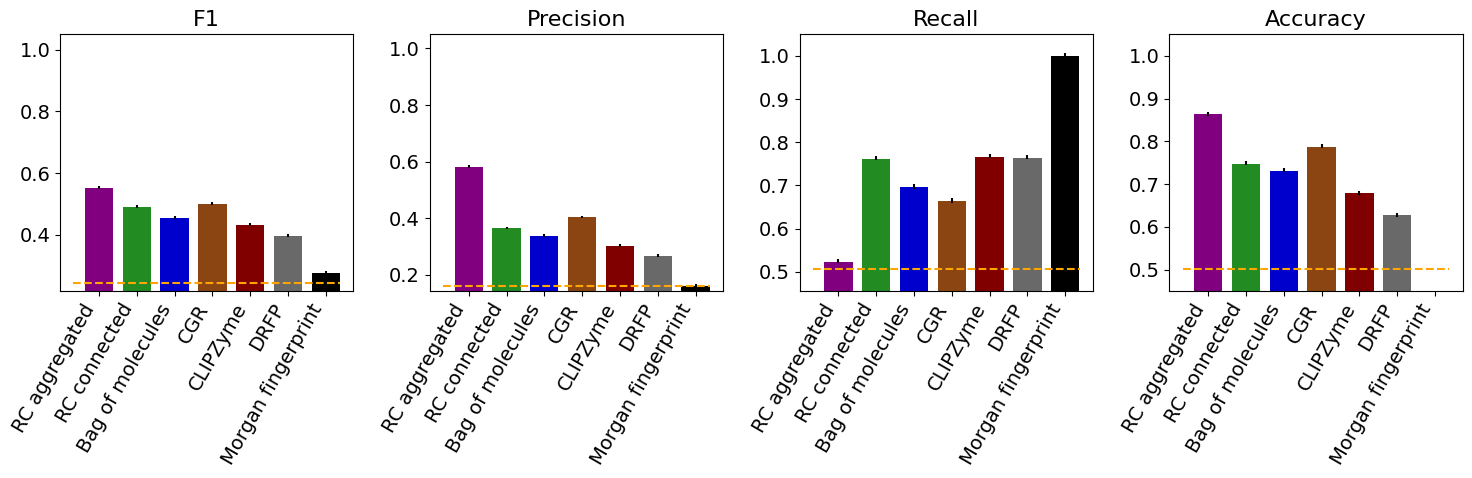

RCMCS - Negative multiple 1


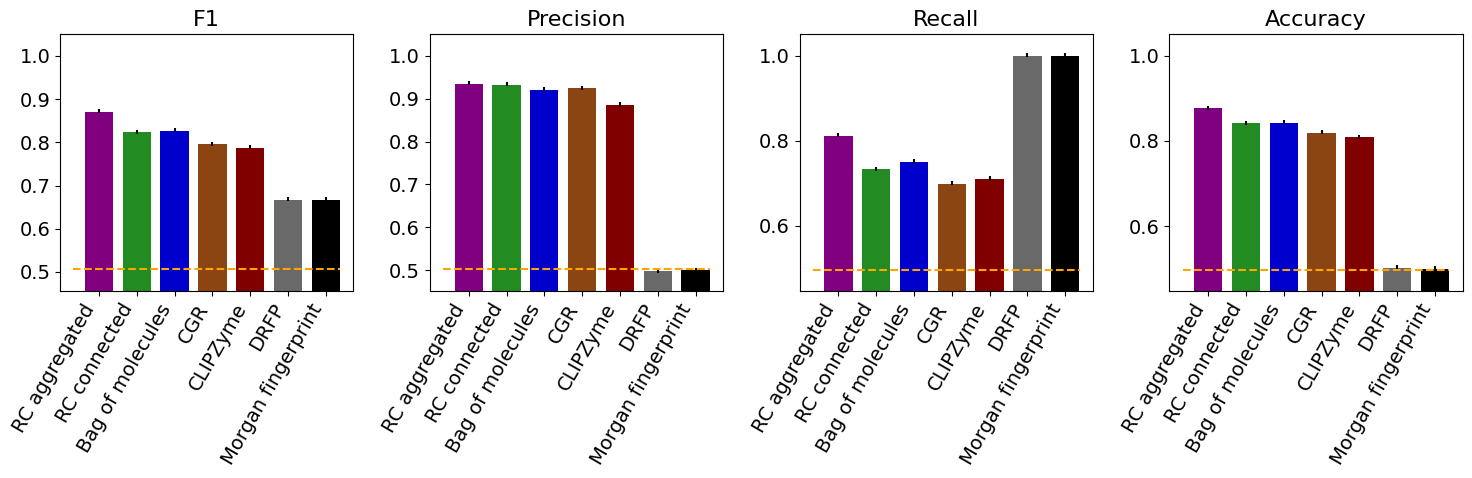

RCMCS - Negative multiple 3


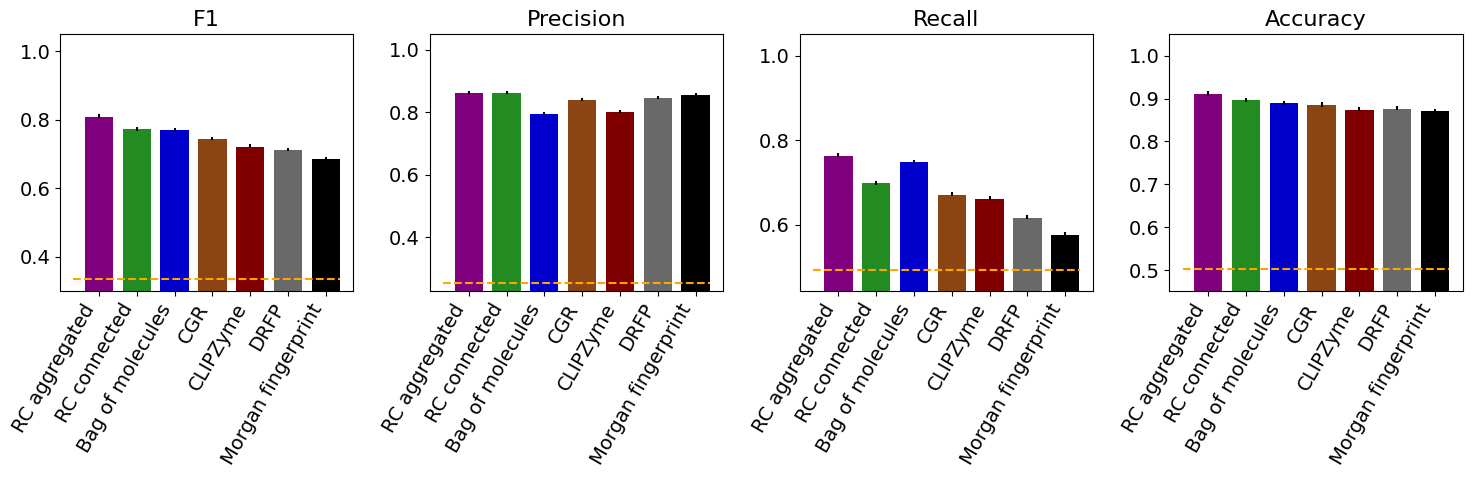

RCMCS - Negative multiple 5


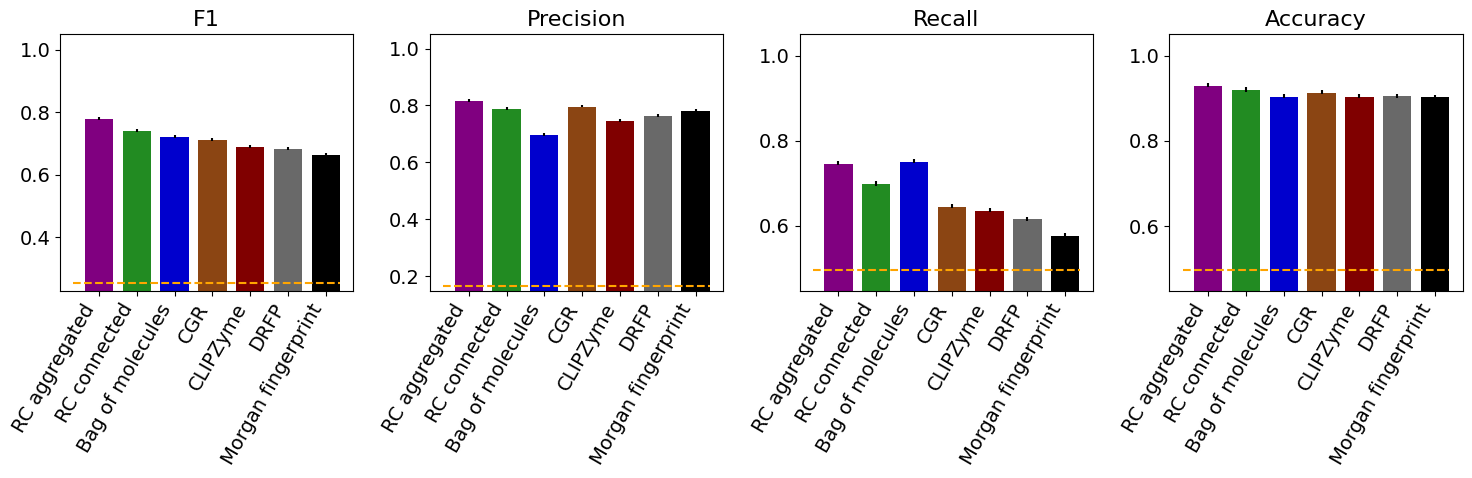

RCMCS - Negative multiple 10


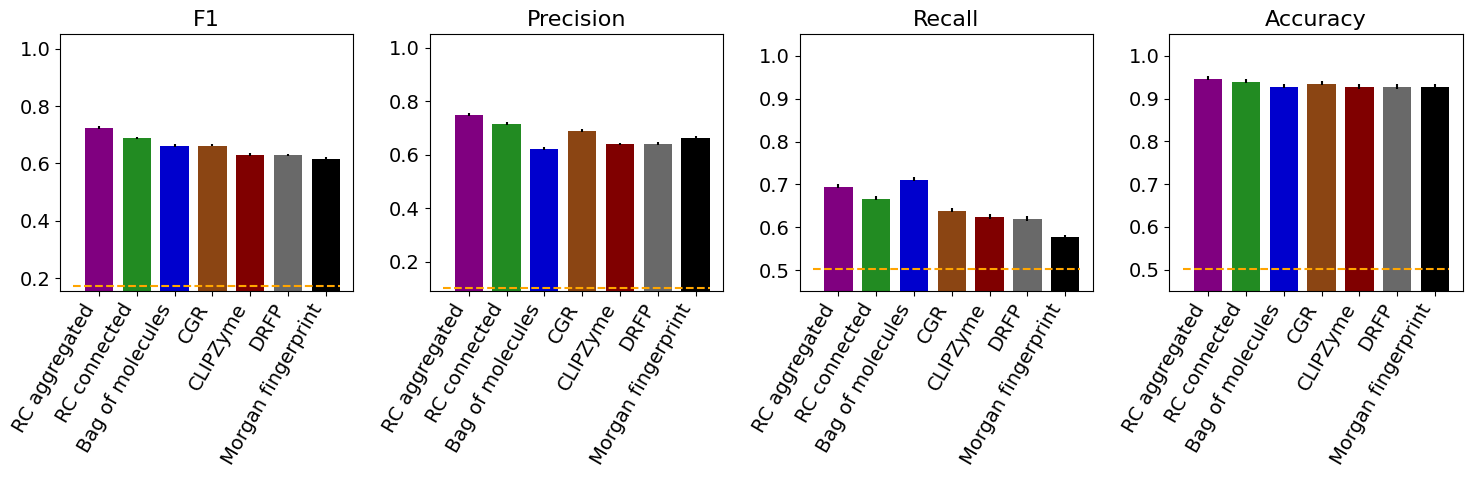

In [14]:
for (strat, nm), df in metrics_table.groupby(['data', 'neg_multiple']):
    fig, ax = plt.subplots(ncols=len(metrics), figsize=figsize, sharey=False)
    for _, row in df.sort_values(by='model', key=get_model_order).iterrows():
        id = row['id']
        model_name = row['model']
        metric_k = row['metric']
        if metric_k not in metrics:
            continue
        i = list(metrics.keys()).index(metric_k)
        
        u, cil, ciu = df.loc[
            (df['id'] == id) & (df['model'] == model_name) & (df['metric'] == metric_k),
            ['mean', 'ci_lower', 'ci_upper']
        ].iloc[0].to_list()
        ci = np.array([auroc_u - auroc_cil, auroc_ciu - auroc_u]).reshape(2, 1)
        ax[i].bar(labels[model_name], height=u, width=width, yerr=ci, color=colors[model_name])
        

        for label in ax[i].get_xticklabels():
            label.set_rotation(xtick_rot)
            label.set_ha(xtick_ha)

    for i in range(len(ax)):
        metric_k = list(metrics.keys())[i]
        ax[i].set_title(metric_names[metric_k])
        _chance = chance[(strat, nm, metric_k)]
        ax[i].set_ylim(scl_chance * _chance, 1.05)
        # Plot horizontal line at chance from min to max x
        x_min, x_max = [0.95 * elt for elt in ax[i].get_xlim()]
        ax[i].hlines(y=_chance, xmin=x_min, xmax=x_max, color=chance_color, linestyle='--')


    print(f"{similarity_names[strat]} - Negative multiple {nm}")
    plt.tight_layout()
    plt.show()        

Performance broken down by similarity bucket

In [28]:
# Clustered bar chart constants

sim_split_bins = {
    'rcmcs': [
        (0.8, 1),
        (0.6, 0.8),
        (0.4, 0.6),
        (0.0, 0.4),
    ],
    'homology': [
        (0.7, 1),
        (0.4, 0.7),
        (0.3, 0.4),
        (0.0, 0.3),
    ],
    'drfp': [
        (0.6, 1),
        (0.4, 0.6),
        (0.2, 0.4),
        (0.0, 0.2),
    ],
    'esm': [
        (0.98, 1),
        (0.97, 0.98),
        # (0.95, 0.97),
        # (0.0, 0.95),
    ]

}

In [29]:
split_metrics_table = []
cols = ['data', 'model', 'neg_multiple', 'sim_split', 'metric', 'mean', 'ci_lower', 'ci_upper', 'id']
for strat, bins in sim_split_bins.items():
    for runid, name in id2name.items():
        if name['data'] != strat:
            continue
        model_name = name['model']
        for nm in nm_keep_indices[runid].keys():
            _target_output = preds[runid].loc[nm_keep_indices[runid][nm]]
            for i, (lb, ub) in enumerate(sim_split_bins[strat]):
                _bin_df = _target_output.loc[(_target_output['max_sim'] >= lb) & (_target_output['max_sim'] < ub)]
                if len(_bin_df) == 0:
                    continue
                for metric_k, metric in discrete_metrics.items():
                    mean, (ci_l, ci_u) = metric(_bin_df['y'].to_numpy(), _bin_df['logits'].to_numpy(), threshold=best_thresholds[runid][nm])
                    split_metrics_table.append(
                        [
                            strat,
                            model_name,
                            nm,
                            (lb, ub),
                            metric_k,
                            mean,
                            ci_l,
                            ci_u,
                            runid
                        ]
                    )
                for metric_k, metric in continuous_metrics.items():
                    mean, (ci_l, ci_u) = metric(_bin_df['y'].to_numpy(), _bin_df['logits'].to_numpy())
                    split_metrics_table.append(
                        [
                            strat,
                            model_name,
                            nm,
                            (lb, ub),
                            metric_k,
                            mean,
                            ci_l,
                            ci_u,
                            runid
                        ]
                    )
split_metrics_table = pd.DataFrame(split_metrics_table, columns=cols)
split_metrics_table.head()

data model  neg_multiple sim_split            metric      mean  ci_lower  \
0  rcmcs   bom             1  (0.8, 1)                f1  0.944628  0.936429   
1  rcmcs   bom             1  (0.8, 1)  binary_precision  0.922980  0.908816   
2  rcmcs   bom             1  (0.8, 1)     binary_recall  0.966371  0.959844   
3  rcmcs   bom             1  (0.8, 1)          accuracy  0.950768  0.945328   
4  rcmcs   bom             1  (0.8, 1)           roc_auc  0.986969  0.982787   

   ci_upper                                id  
0  0.950588  ff90895a6070499b8fdcdc0982526885  
1  0.937843  ff90895a6070499b8fdcdc0982526885  
2  0.975409  ff90895a6070499b8fdcdc0982526885  
3  0.955292  ff90895a6070499b8fdcdc0982526885  
4  0.990691  ff90895a6070499b8fdcdc0982526885

In [30]:
bins2labels = lambda bins: [f"[{b[0]}, {b[1]})" for b in bins]

bar_shifts = {k: i for i, k in enumerate(labels.keys())}

width = 0.12
space = 1.03
offset = (len(labels) / 2) * width
figsize = (13, 3.5)
metrics_of_i = [
    'f1',
    'roc_auc',
    # 'accuracy'
]

drfp 1


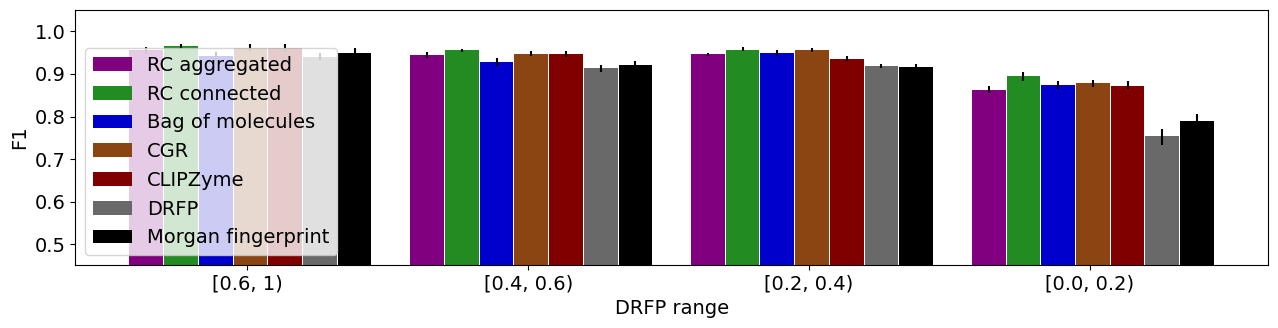

drfp 3


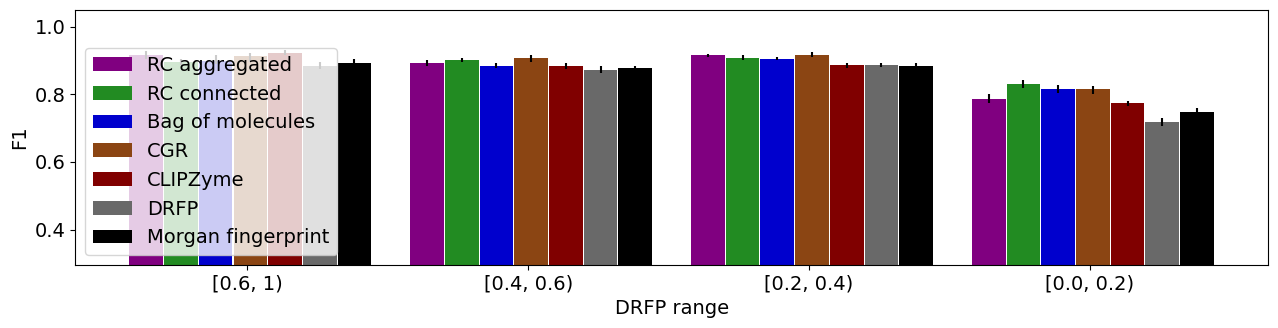

drfp 5


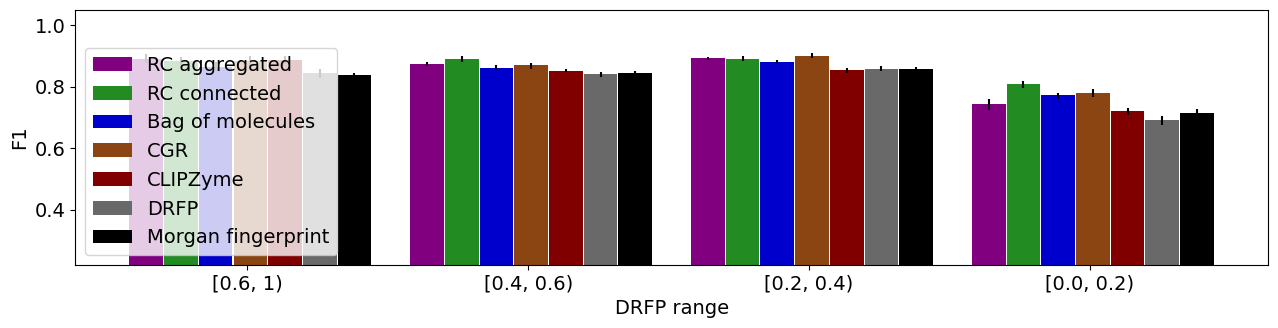

drfp 10


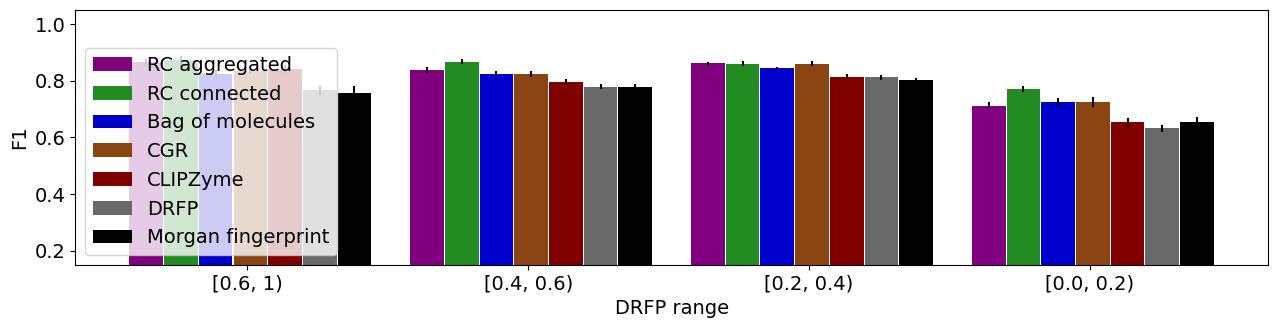

drfp 1


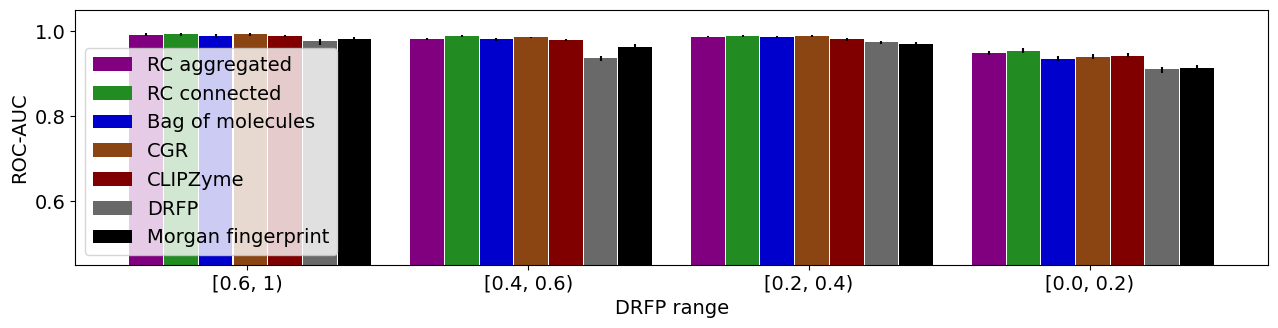

drfp 3


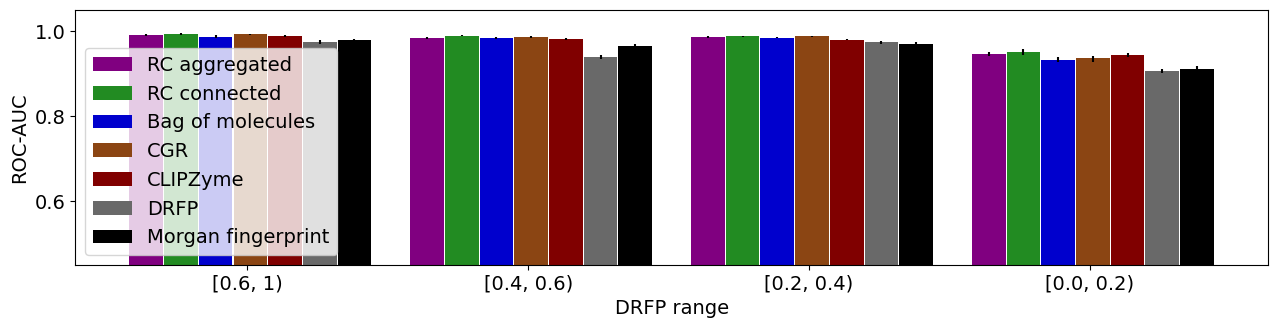

drfp 5


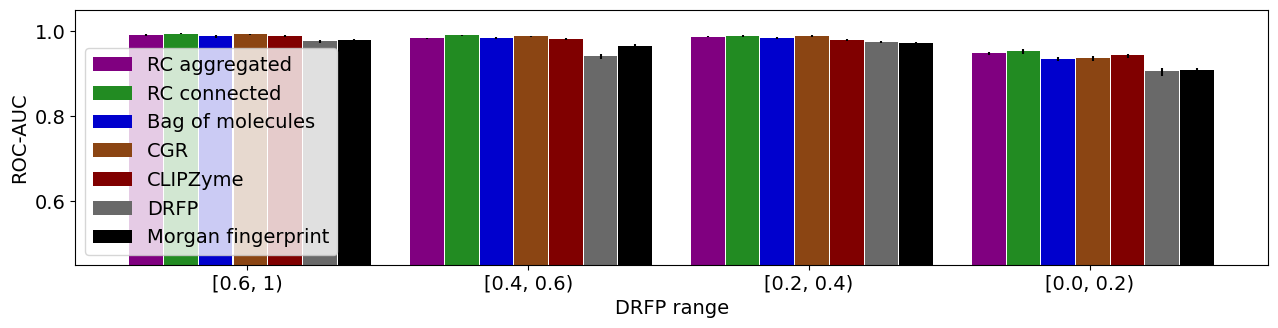

drfp 10


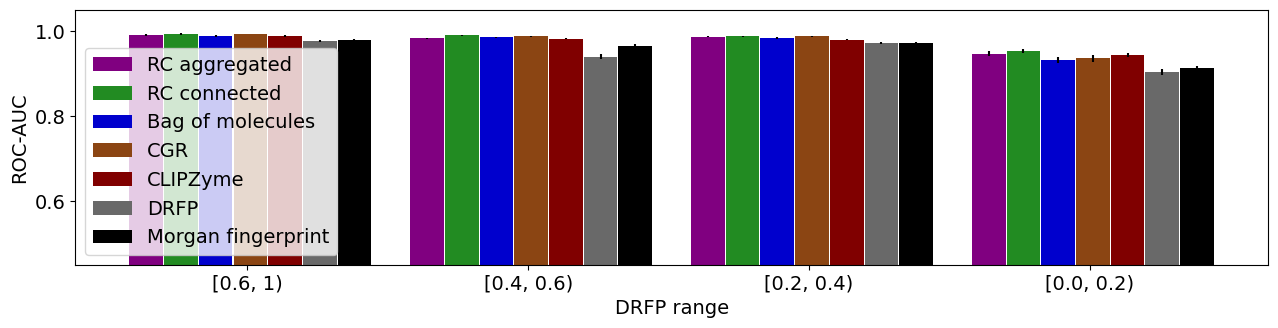

esm 1


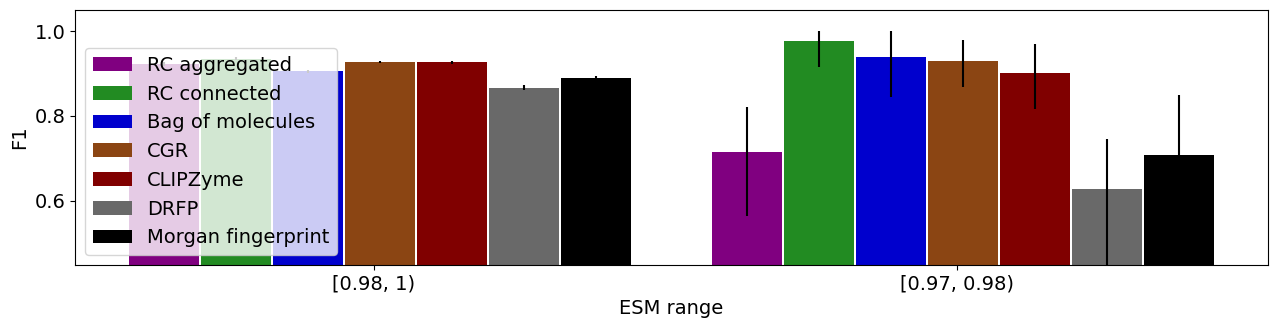

esm 3


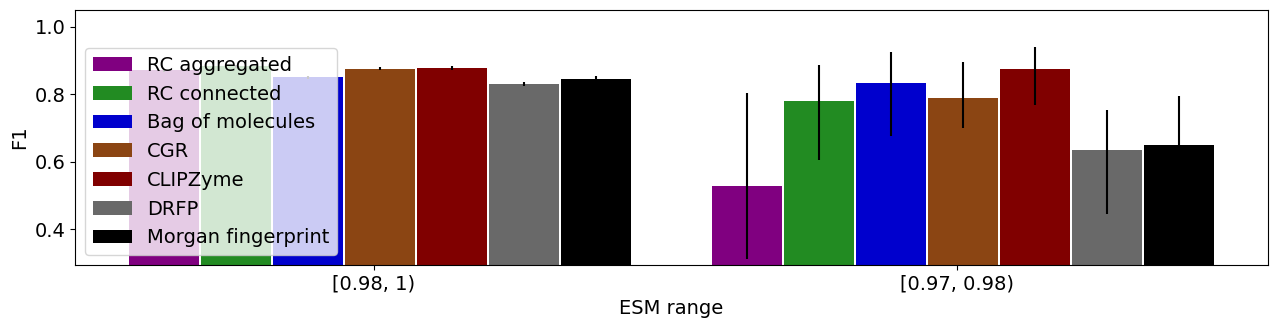

esm 5


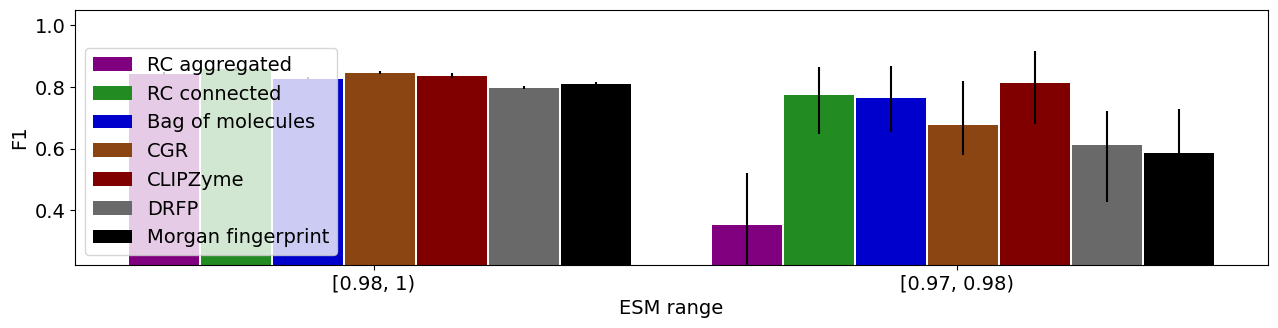

esm 10


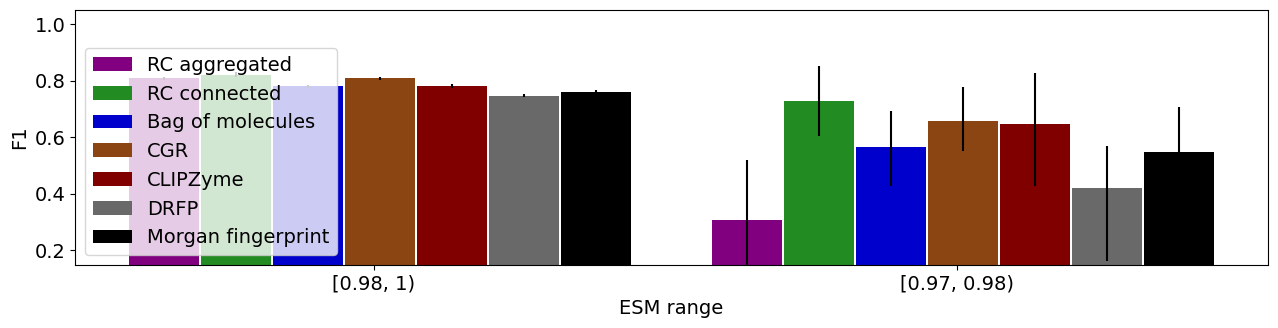

esm 1


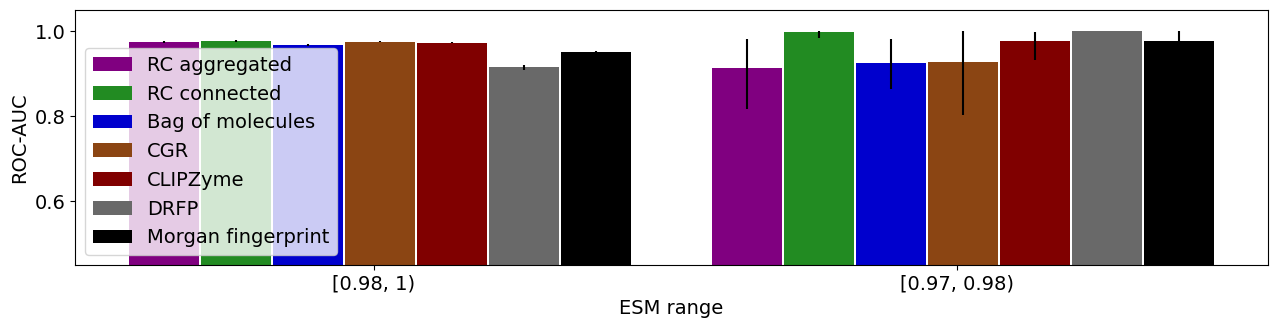

esm 3


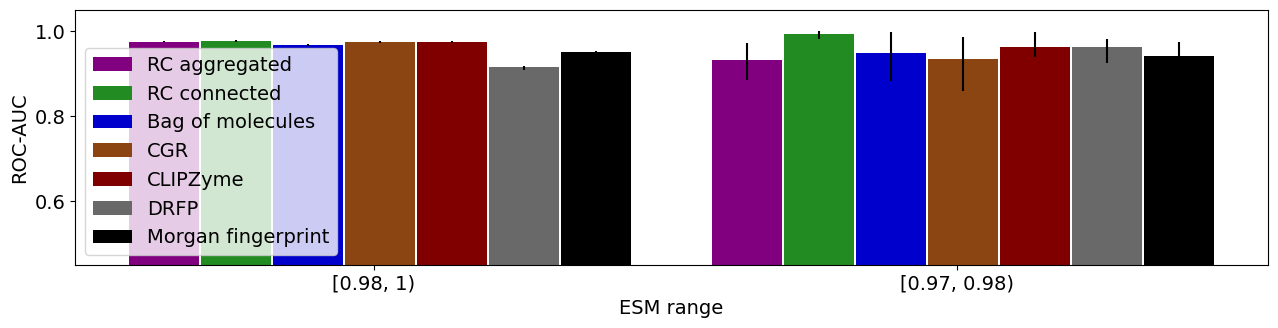

esm 5


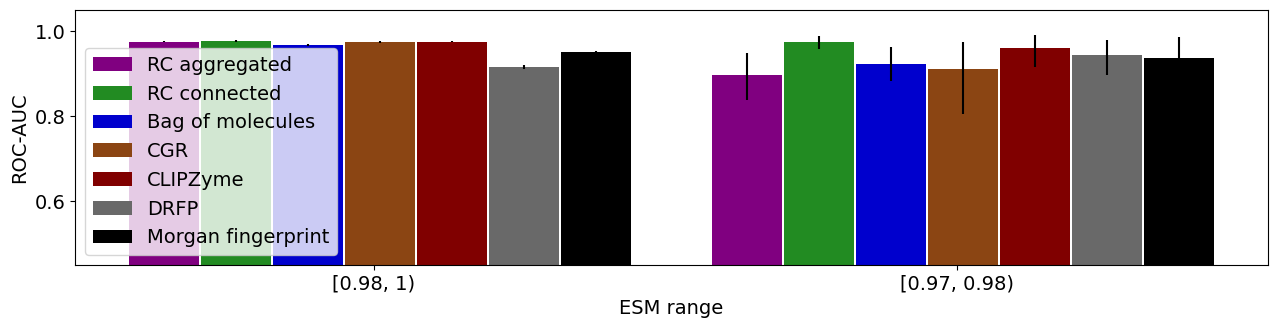

esm 10


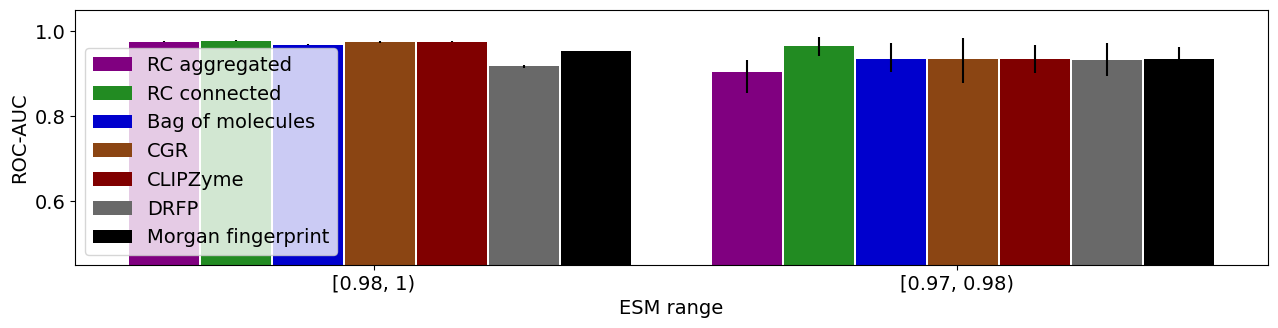

homology 1


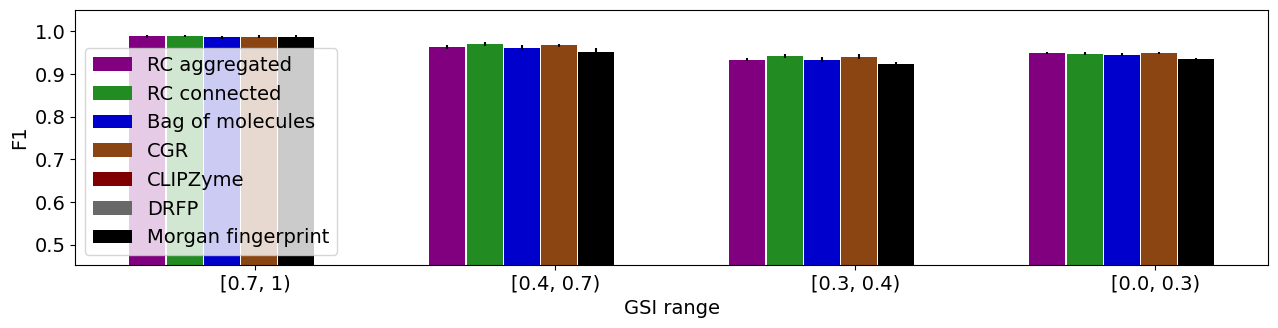

homology 3


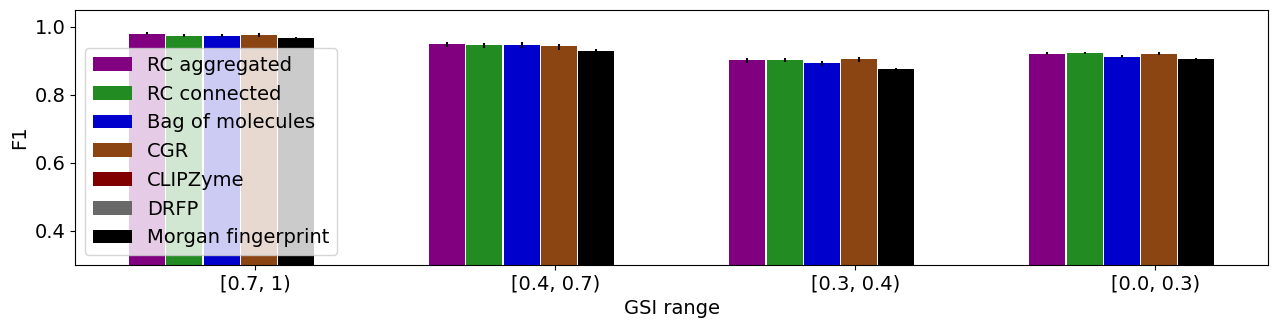

homology 5


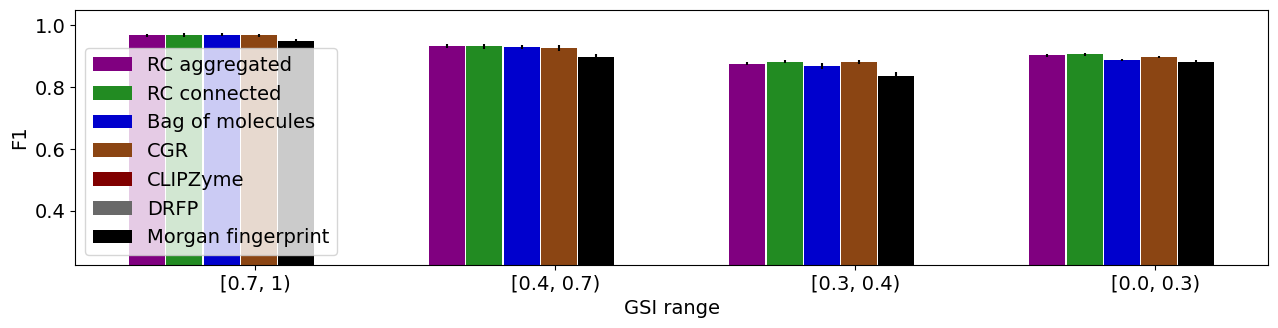

homology 10


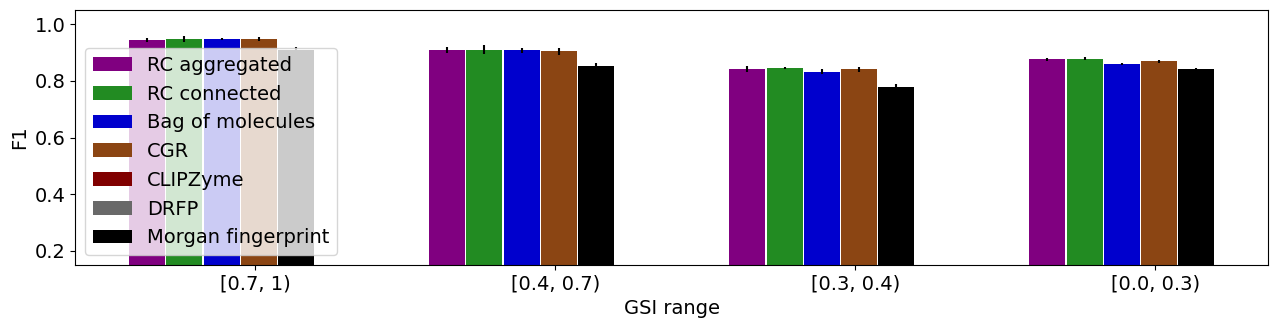

homology 1


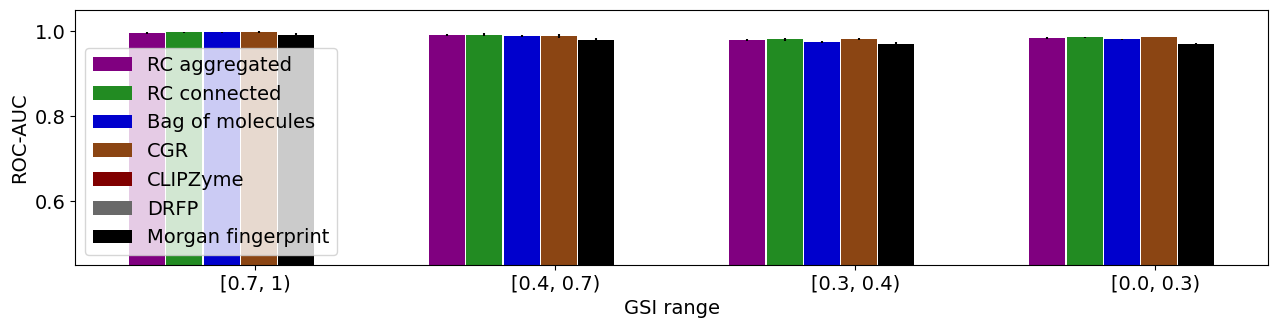

homology 3


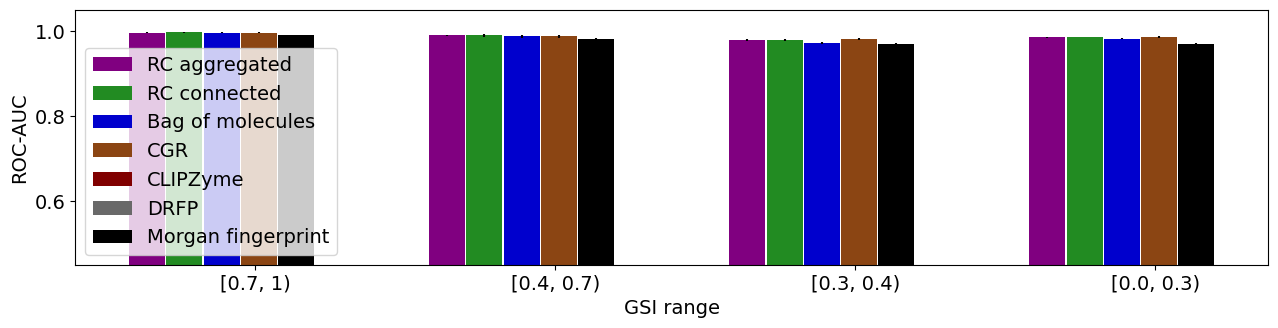

homology 5


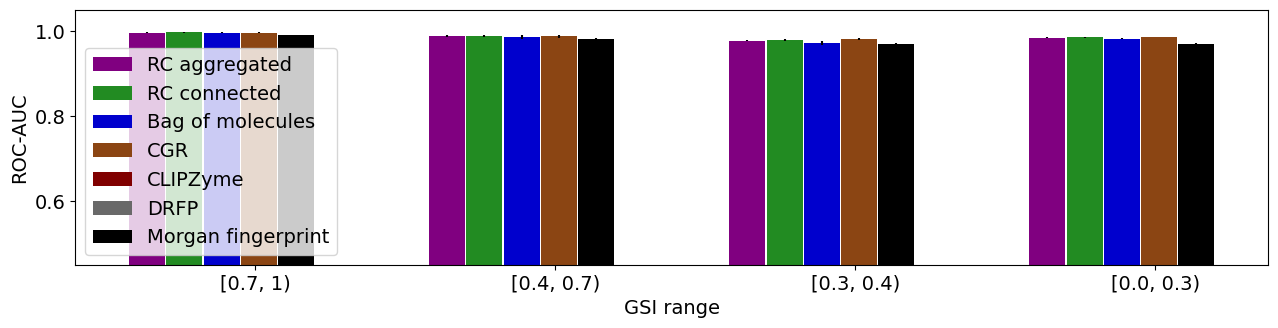

homology 10


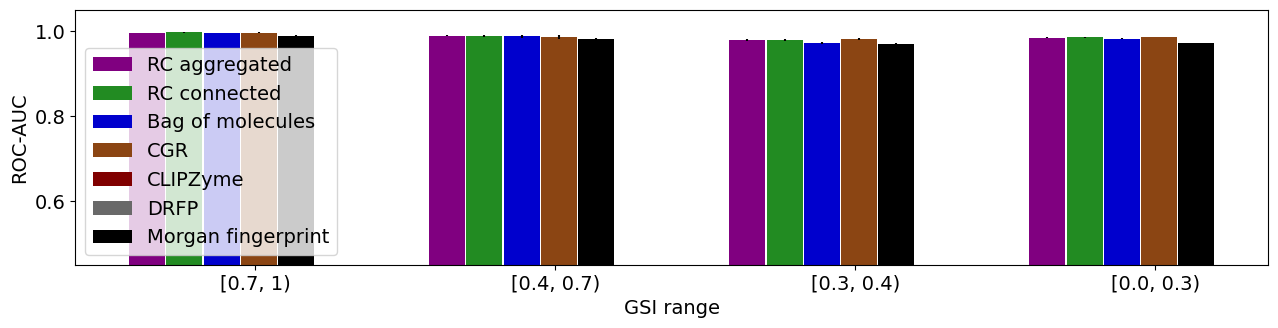

rcmcs 1


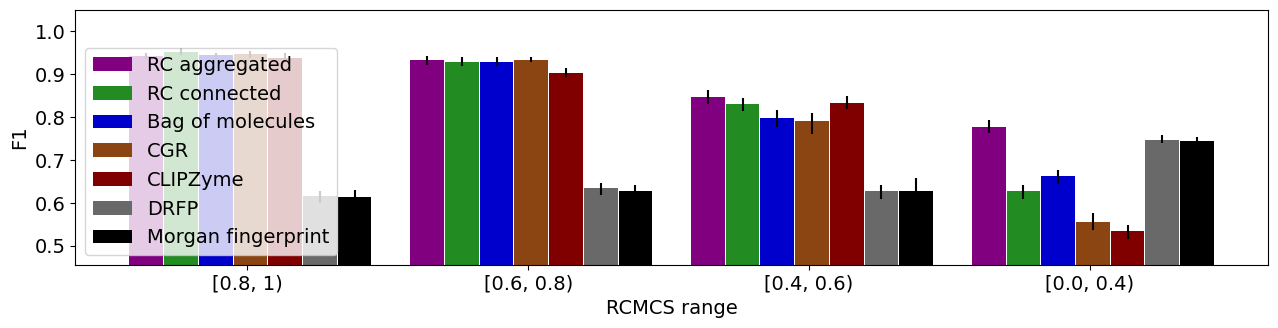

rcmcs 3


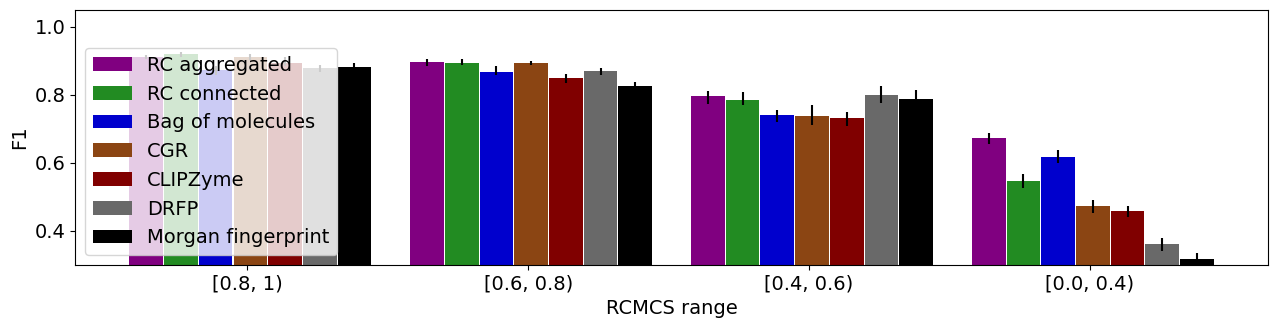

rcmcs 5


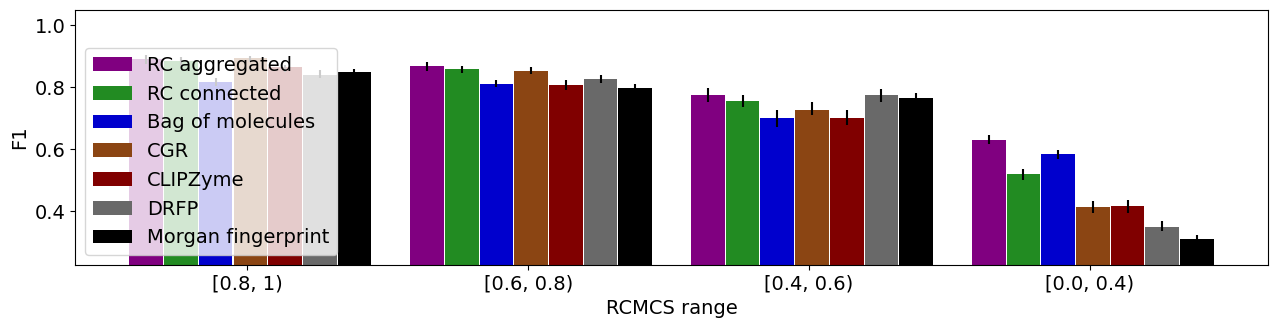

rcmcs 10


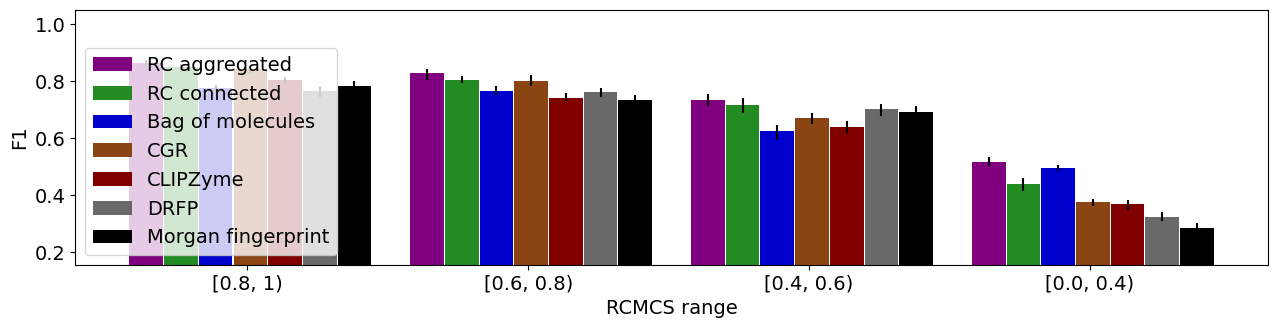

rcmcs 1


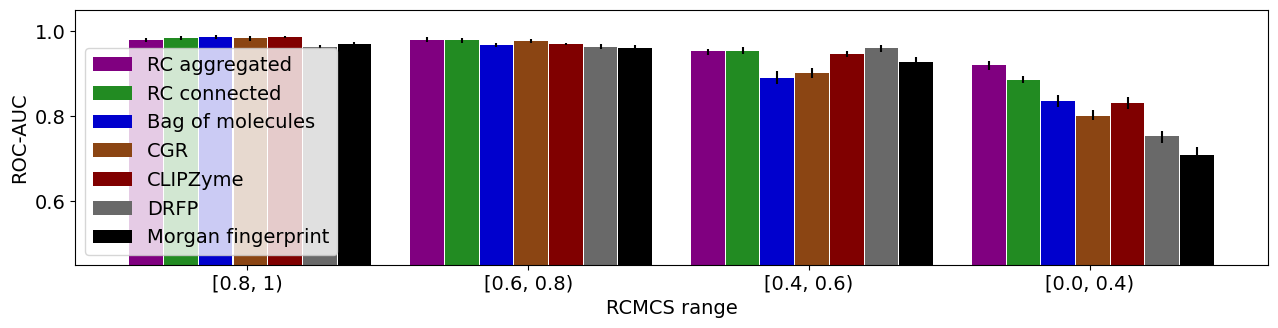

rcmcs 3


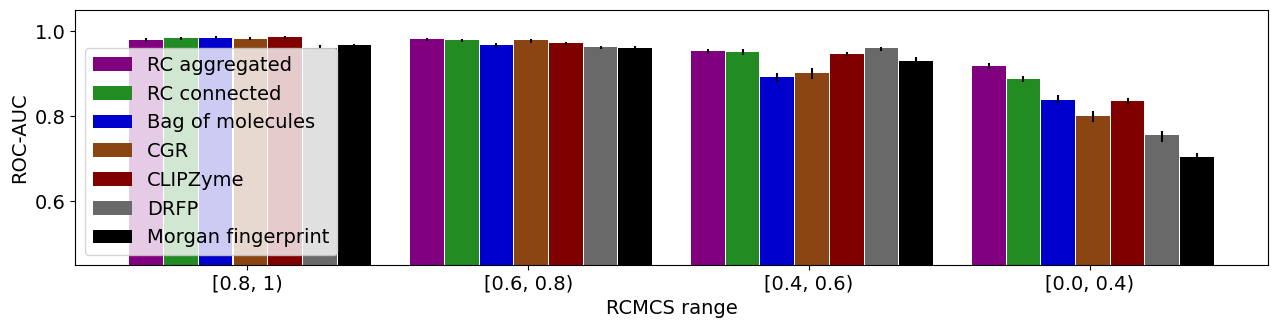

rcmcs 5


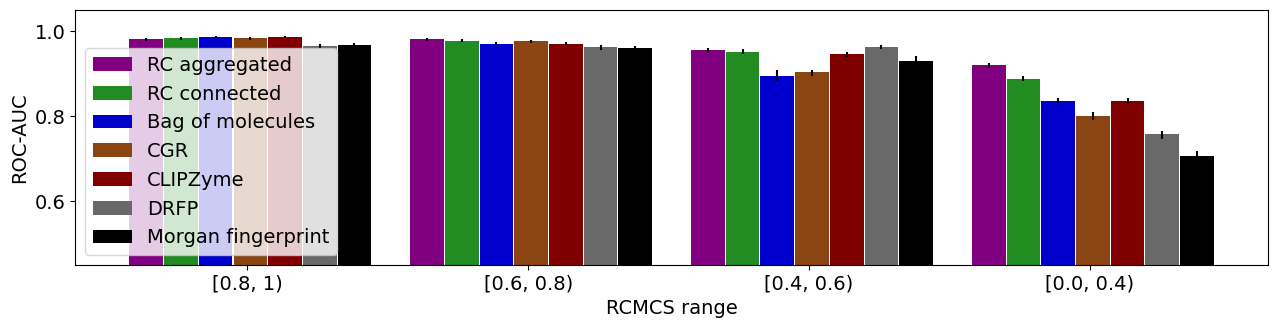

rcmcs 10


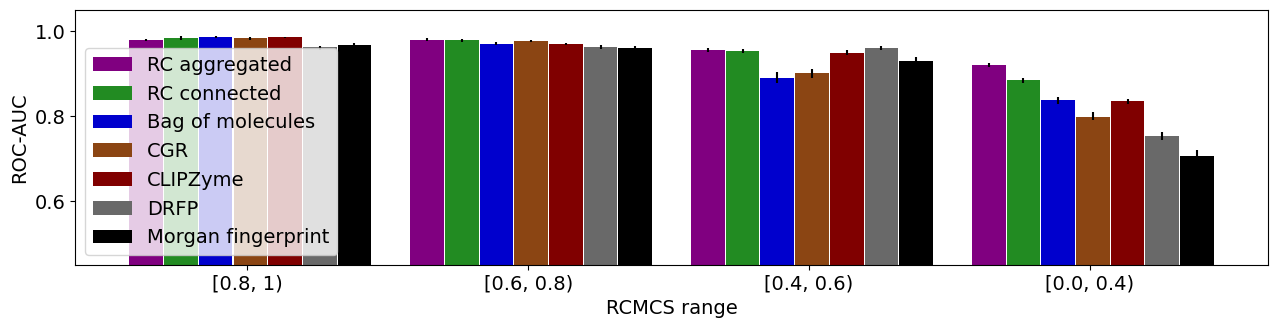

In [ ]:
for (strat, metric_k, nm), df in split_metrics_table.groupby(['data', 'metric', 'neg_multiple']):
    if metric_k not in metrics_of_i:
        continue
    print(strat, nm)
    fig, ax = plt.subplots(figsize=figsize, sharey=True)
    for (lb, ub), bunch in df.groupby('sim_split'):
        j = 0
        for _, row in bunch.sort_values(by='model', key=get_model_order).iterrows():
            x = sim_split_bins[strat].index(row['sim_split'])
            model_name = row['model']
            val = row['mean']
            ci = np.array([row['mean'] - row['ci_lower'], row['ci_upper'] - row['mean']]).reshape(2, 1)
            ax.bar(x=x - offset + width * j * space, height=val, yerr=ci, width=width, color=colors[model_name])
            j += 1

    for key in labels:
        ax.bar(0, 0, color=colors[key], label=labels[key])
    
    # ax.set_ylim(*ylim[strat])
    _chance = chance.get((strat, nm, metric_k), 0.5)
    ax.set_ylim(scl_chance * _chance, 1.05)
    ax.set_xticks(np.arange(len(sim_split_bins[strat])) - width / 2)
    ax.set_xticklabels(bins2labels(sim_split_bins[strat]))
    ax.set_ylabel(metric_names[metric_k])
    ax.set_xlabel(f"{similarity_names[strat]} range")
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig(save_to / f"{strat}_similarity_clustered_{metric_names[metric_k]}.svg")
    plt.show()
            

In [27]:
split_metrics_table.loc[
    (split_metrics_table['data'] == 'rcmcs') &
    (split_metrics_table['neg_multiple'] == 10) &
    (split_metrics_table['metric'] == 'roc_auc') &
    (split_metrics_table['sim_split'] == (0, 0.4))
]

data     model  neg_multiple   sim_split   metric      mean  ci_lower  \
79   rcmcs       bom            10  (0.0, 0.4)  roc_auc  0.836533  0.827739   
159  rcmcs    rc_agg            10  (0.0, 0.4)  roc_auc  0.921334  0.916188   
239  rcmcs    rc_cxn            10  (0.0, 0.4)  roc_auc  0.884482  0.879858   
319  rcmcs       mfp            10  (0.0, 0.4)  roc_auc  0.704542  0.695415   
399  rcmcs       cgr            10  (0.0, 0.4)  roc_auc  0.797193  0.785474   
479  rcmcs      drfp            10  (0.0, 0.4)  roc_auc  0.756533  0.746564   
559  rcmcs  clipzyme            10  (0.0, 0.4)  roc_auc  0.836800  0.830616   

     ci_upper                                                id  
79   0.847364                  ff90895a6070499b8fdcdc0982526885  
159  0.923850                  8a155bc5673b4c6aa8667dd55755fe0b  
239  0.888622                  5ca6ba7b8aec4b81a366e9138b9c09b0  
319  0.714236                  fb3c7a9061a744fba7dabf9d50092414  
399  0.805260                  2a7b803f790143f0b14a1955117cb393  
479  0.765409                  1a6a3a1a203f40b1bf7c969585e96ff8  
559  0.842033  clipzyme/sprhea_v3_folded_pt_ns_rcmcs_outer_fold

In [ ]:
# best_thresholds = {
#     'ff90895a6070499b8fdcdc0982526885': 0.010101010101010102,
#     '8a155bc5673b4c6aa8667dd55755fe0b': 0.010101010101010102,
#     '5ca6ba7b8aec4b81a366e9138b9c09b0': 0.010101010101010102,
#     '2241478505f9497885d25b9a0dee3ffd': 0.15151515151515152,
#     'e638683b53f84d0ba1c8f32794413e0e': 0.12121212121212122,
#     'fb3c7a9061a744fba7dabf9d50092414': 0.010101010101010102,
#     '4bf93c6830744a4b8e6d8076f14a82e1': 0.05050505050505051,
#     'ef2ce94281fb445ba304791f991e23cc': 0.26262626262626265,
#     '3c1ce655b064442cb7789fa210e4caaf': 0.21212121212121213,
#     '2a7b803f790143f0b14a1955117cb393': 0.010101010101010102,
#     '84eab00d36354c1bac700bd82b9b222c': 0.25252525252525254,
#     'e48cb2b15ee94a3aae6e3b324d3d8aba': 0.17171717171717174,
#     'b1f3ce077f454c828d0837acbac7bb6e': 0.26262626262626265,
#     'd898b47a73984726bb593a3a19a6b2ec': 0.30303030303030304,
#     'f3bbad9576cd45f69569f7914c5a8b18': 0.37373737373737376,
#     'd618e5ac38c24e089a5c477dc8902f09': 0.010101010101010102,
#     '28ebdae603464197a6ac0ecb38469b6f': 0.010101010101010102,
#     '311eda1797af4cfaa2eb7067655a381b': 0.010101010101010102,
#     'be7e38c4676e4e5ebc3caf2adcd76ca7': 0.010101010101010102,
#     '36bb12690dda4298bccd1a8a63930e53': 0.030303030303030304,
#     'a9f2dce71dc041e0a76c1663b5d9b41d': 0.5757575757575758,
#     'f43941db95544e59a3e2b584b9aee567': 0.595959595959596,
#     '6576cf8c65be40c5a1573685f0727082': 0.14141414141414144,
#     '199d3b61c7c1450aa7176fb0735de21e': 0.494949494949495,
#     '1e871b45c8bc46fab2da4c233681be3a': 0.38383838383838387,
#     '36be3d0aca6d4b42804e6670437da7e4': 0.05050505050505051,
#     '412c8627a31b4ba7a40967d344ae4745': 0.05050505050505051,
#     '0d61a0f54d54424a82760f42bd4698ab': 0.010101010101010102,
#     '547968f96d9a45da91a9d5808fd5345c': 0.010101010101010102,
#     '3d30cac508c542b1b61590a45d6c687a': 0.04040404040404041
# }

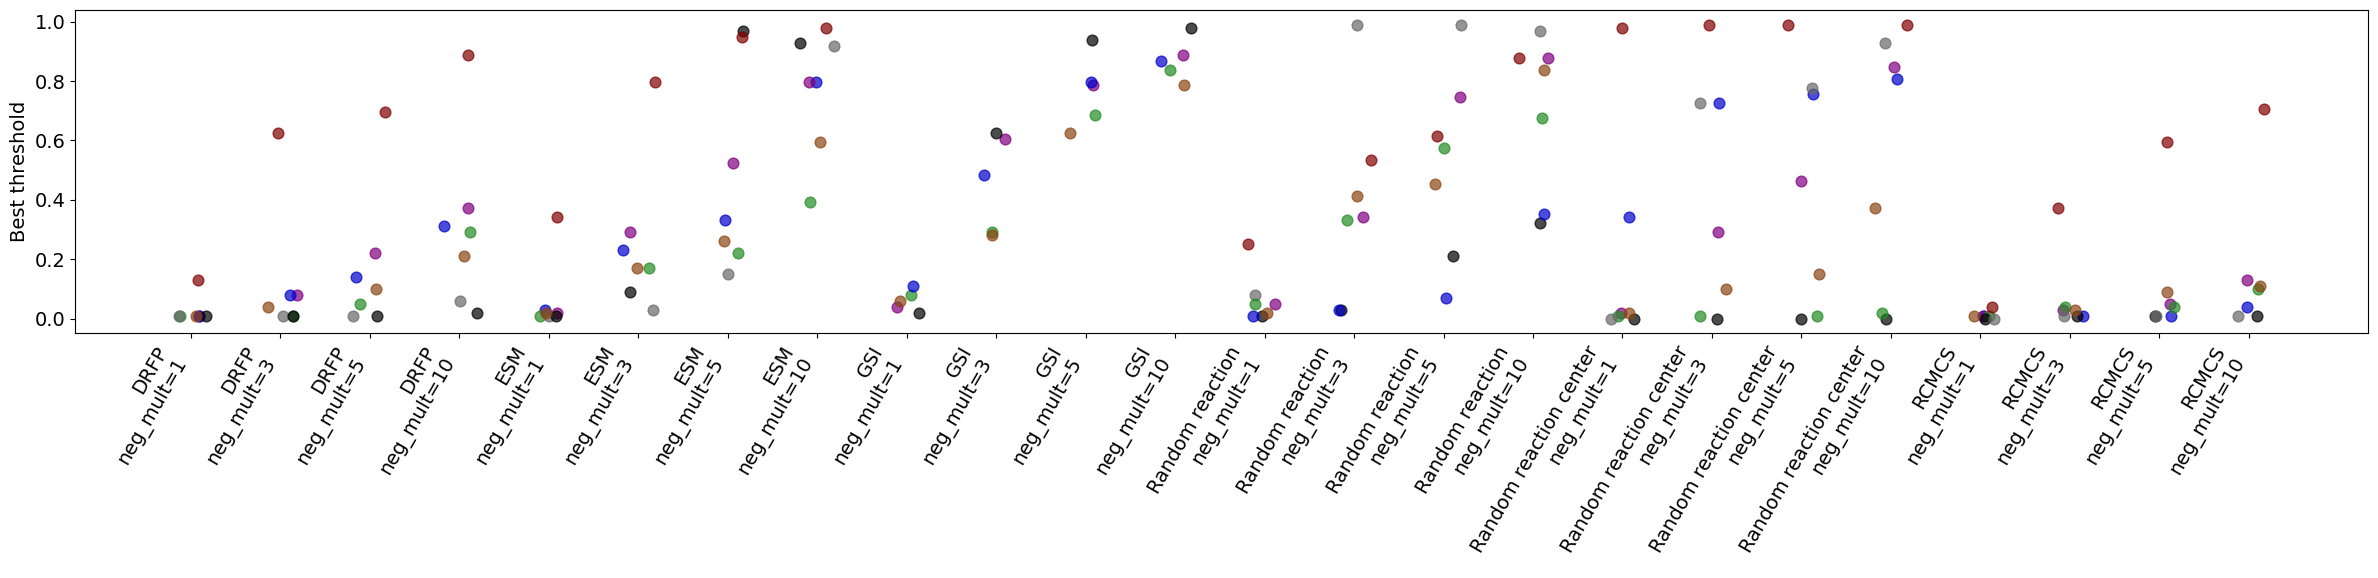

In [ ]:
# Collect thresholds for each (data, neg_multiple, model) combo
scatter_data = []
for id, name in id2name.items():
    for nm, th in best_thresholds.get(id, {}).items():
        scatter_data.append((name['data'], nm, name['model'], th))

# Prepare unique (data, neg_multiple) combos and mapping
combos = sorted(set((d, nm) for d, nm, _, _ in scatter_data))
combo2x = {combo: i for i, combo in enumerate(combos)}

plt.figure(figsize=(max(8, len(combos)), 6))
for d, nm, m, th in scatter_data:
    x = combo2x[(d, nm)] + np.random.uniform(-0.2, 0.2)
    plt.scatter(x, th, alpha=0.7, s=60, label=m, color=colors.get(m, 'gray'))

plt.xticks(
    range(len(combos)),
    [f"{similarity_names.get(d, d)}\nneg_mult={nm}" for d, nm in combos],
    rotation=60,
    ha='right'
)
plt.ylabel("Best threshold")
plt.tight_layout()
plt.show()


In [ ]:
from collections import defaultdict

# Check if indices are identical for each (data, neg_multiple) combo across models

# Group indices by (data, neg_multiple)
combo_indices = defaultdict(list)
for id, nm_dict in nm_keep_indices.items():
    data = id2name[id]['data']
    for nm, idxs in nm_dict.items():
        combo_indices[(data, nm)].append((id, idxs))

# Report mismatches
for combo, id_idx_list in combo_indices.items():
    # Use the first set of indices as reference
    ref_idxs = id_idx_list[0][1]
    for id, idxs in id_idx_list[1:]:
        if not np.array_equal(ref_idxs, idxs):
            print(f"Mismatch for {combo} between models: {id_idx_list[0][0]} and {id}")
        else:
            print(f"Indices match for {combo} between models: {id_idx_list[0][0]} and {id}")

Indices match for ('rcmcs', 1) between models: ff90895a6070499b8fdcdc0982526885 and 8a155bc5673b4c6aa8667dd55755fe0b
Indices match for ('rcmcs', 1) between models: ff90895a6070499b8fdcdc0982526885 and 5ca6ba7b8aec4b81a366e9138b9c09b0
Indices match for ('rcmcs', 1) between models: ff90895a6070499b8fdcdc0982526885 and fb3c7a9061a744fba7dabf9d50092414
Indices match for ('rcmcs', 1) between models: ff90895a6070499b8fdcdc0982526885 and 2a7b803f790143f0b14a1955117cb393
Indices match for ('rcmcs', 1) between models: ff90895a6070499b8fdcdc0982526885 and 1a6a3a1a203f40b1bf7c969585e96ff8
Indices match for ('rcmcs', 1) between models: ff90895a6070499b8fdcdc0982526885 and clipzyme/sprhea_v3_folded_pt_ns_rcmcs_outer_fold
Indices match for ('rcmcs', 3) between models: ff90895a6070499b8fdcdc0982526885 and 8a155bc5673b4c6aa8667dd55755fe0b
Indices match for ('rcmcs', 3) between models: ff90895a6070499b8fdcdc0982526885 and 5ca6ba7b8aec4b81a366e9138b9c09b0
Indices match for ('rcmcs', 3) between models: f